## Objective
Run algorithm on spikeinterface recording

si_rec8.ipynb -> si_rec9.ipynb: Starting to use methods google doc (many improvements). Also si_rec8 is used for patch clamp recording before improvements are implemented, so I could work on this script while running si_rec8

copy is for running on /data/MEAprojects/primary_mouse/tau/231111/22283/Network/000155 and 000157

## Globals setup

In [2]:
%load_ext autoreload
%env HDF5_PLUGIN_PATH /home/mea/SpikeSorting/spikeinterface

env: HDF5_PLUGIN_PATH=/home/mea/SpikeSorting/spikeinterface


In [3]:
from copy import deepcopy
from importlib import reload
from multiprocessing import Pool
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
import numpy as np

from diptest import diptest  # Only for testing
from tqdm import tqdm


%autoreload 2
from src import utils
from src.recording import Recording
from src.sorters.base import Unit

from src.run_alg import si_rec9 as F  # This forces you to manually reload every time modification happens (prevents forgetfulness errors)

In [3]:
# CALLED FRAMES BUT IS ACTUALLY IN ms
# TRAINING_MS = (0, 5*60*1000)  # 0 min to 5 min in recording (in ms)
# TESTING_MS = (5*60*1000, 10*60*1000)  # 5 min to 10 min in recording (in ms)

TRAINING_MS = TESTING_MS = (0, 1800000)

In [4]:
# RECORDING = utils.rec_si()
from spikeinterface.extractors import MaxwellRecordingExtractor
RECORDING = Recording(MaxwellRecordingExtractor("/data/MEAprojects/primary_mouse/tau/231111/22283/Network/000155/data.raw.h5"))

##
# CHANS_RMS = utils.chans_rms_si()
CHANS_RMS = np.full(RECORDING.get_num_channels(), np.inf)

SAMP_FREQ = RECORDING.get_sampling_frequency()
NUM_ELECS = RECORDING.get_num_channels()
ELEC_LOCS = RECORDING.get_channel_locations()

In [5]:
ALL_CLOSEST_ELECS = []
for elec in range(NUM_ELECS):
    elec_ind = []
    dists = []
    x1, y1 = ELEC_LOCS[elec]
    for elec2 in range(RECORDING.get_num_channels()):
        if elec == elec2:
            continue
        x2, y2 = ELEC_LOCS[elec2]
        dists.append(np.sqrt((x2 - x1)**2 + (y2 - y1)**2))
        elec_ind.append(elec2)
    order = np.argsort(dists)
    ALL_CLOSEST_ELECS.append(np.array(elec_ind)[order])   

In [6]:
ALL_CROSSINGS = np.load("/data/MEAprojects/primary_mouse/tau/231111/22283/Network/000155/rt_sort/all_crossings.npy", allow_pickle=True)
ALL_CROSSINGS = [tuple(cross) for cross in ALL_CROSSINGS]

ELEC_CROSSINGS_IND = np.load("/data/MEAprojects/primary_mouse/tau/231111/22283/Network/000155/rt_sort/elec_crossings_ind.npy", allow_pickle=True)
ELEC_CROSSINGS_IND = [tuple(ind) for ind in ELEC_CROSSINGS_IND]  # [(elec's cross times ind in all_crossings)]

In [7]:
TRACES_PATH = "/data/MEAprojects/primary_mouse/tau/231111/22283/Network/000155/rt_sort/traces.npy"
TRACES_FILT_PATH = "/data/MEAprojects/primary_mouse/tau/231111/22283/Network/000155/rt_sort/traces.npy"
MODEL_OUTPUTS_PATH = "/data/MEAprojects/primary_mouse/tau/231111/22283/Network/000155/rt_sort/outputs.npy"
FRONT_BUFFER = 40  # Model's front sample buffer

In [8]:
class TracesFiltWrapper:
    """
    Wrapper for RECORDING so it can be used for TRACES_FILT
    """
    def __init__(self, recording):
        self.recording = recording
        self.chans = range(recording.get_num_channels())
        # self.frames = range(recording.get_total_samples()) 
        self.shape = (recording.get_num_channels(), recording.get_total_samples())
        
    def __getitem__(self, idx):
        chans, frames = idx  # unpacking like this is okay since TRACES_FILT[:] is never called
        chans = self.chans[chans]
        return self.recording.get_traces_filt(frames.start, frames.stop, chans)
TRACES_FILT = TracesFiltWrapper(RECORDING)

In [9]:
# Set global variables in .py
reload(F)

F.RECORDING = RECORDING
F.CHANS_RMS = CHANS_RMS
F.SAMP_FREQ = SAMP_FREQ
F.NUM_ELECS = NUM_ELECS
F.ELEC_LOCS = ELEC_LOCS

F.ALL_CLOSEST_ELECS = ALL_CLOSEST_ELECS

F.ALL_CROSSINGS = ALL_CROSSINGS
F.ELEC_CROSSINGS_IND = ELEC_CROSSINGS_IND

F.TRACES_FILT_PATH = TRACES_FILT_PATH
F.MODEL_OUTPUTS_PATH = MODEL_OUTPUTS_PATH
F.FRONT_BUFFER = FRONT_BUFFER

# TODO: Make sure traces is in (num_elecs, num_samples) format
F.TRACES = np.load(TRACES_PATH, mmap_mode="r")  # NOTE: 12/10/23 For neuropixels, these are AFTER multiplying by gain_to_uv
F.TRACES_FILT = TRACES_FILT # np.load(TRACES_FILT_PATH, mmap_mode="r")
F.OUTPUTS = np.load(MODEL_OUTPUTS_PATH, mmap_mode="r")

F.N_BEFORE = F.N_AFTER = round(0.5 * SAMP_FREQ)  # Window for looking for electrode codetections

## Form propagations

### Development

In [40]:
# form_from_root
root_elec=340
time_frame=TRAINING_MS
verbose=True

coc_clusters = F.form_coc_clusters(root_elec, time_frame, 
                                   verbose=verbose)
F.setup_coc_clusters(coc_clusters)

Starting with elec 340, loc: [437.5 682.5]

Finding coocurrences


100%|██████████| 7491/7491 [00:02<00:00, 2928.76it/s]


158 cocs total

Unimodal amp/median with p-value: 0.824

Comparing to elec 332, loc: [437.5 717.5]
Found 1 clusters
136 cocs remaining
Patience counter: 0/6

Comparing to elec 344, loc: [472.5 682.5]
Found 1 clusters
110 cocs remaining
Patience counter: 0/6

Comparing to elec 112, loc: [402.5 717.5]
Found 2 clusters
83 cocs remaining
Patience counter: 0/6

Comparing to elec 184, loc: [472.5 717.5]
Found 1 clusters
65 cocs remaining
Patience counter: 0/6

Total: 5 clusters


 20%|█▉        | 1830498/9334268 [00:42<00:07, 950933.28it/s]

In [49]:
# # Reset spike trains
# for cluster in coc_clusters:
#     cluster._spike_train = cluster.formation_spike_train

F.assign_spikes(coc_clusters, time_frame, verbose=verbose)

100%|██████████| 9334268/9334268 [00:38<00:00, 243672.81it/s]


1302


In [47]:
for cluster in coc_clusters:
    print(len(cluster.spike_train))

0
0
0
0
3


In [35]:
coc_clusters = [c for c in coc_clusters if len(c._spike_train) > 0]
merged_clusters = F.merge_coc_clusters(deepcopy(coc_clusters), verbose=True, auto_setup_coc_clusters=False)


Formed 0 merged clusters:


In [24]:
cluster = coc_clusters[0]
for elec in cluster.loose_elecs:
    print(f"{elec}, {ELEC_LOCS[elec]}: {cluster.all_elec_probs[elec]*100:.2f}")

112, [402.5 717.5]: 14.77
113, [1557.5 1137.5]: 10.22
141, [1592.5  752.5]: 10.94
184, [472.5 717.5]: 10.70
196, [437.5 752.5]: 10.51
240, [402.5 752.5]: 11.43
315, [1732.5 1242.5]: 11.17
332, [437.5 717.5]: 40.23
340, [437.5 682.5]: 57.53
344, [472.5 682.5]: 19.22
413, [1172.5 1242.5]: 10.02
506, [ 192.5 2047.5]: 12.71
567, [1697.5 1452.5]: 10.47
639, [2432.5 1907.5]: 14.95
679, [2537.5 1872.5]: 15.44
770, [1312.5 1382.5]: 10.68
815, [1557.5 1032.5]: 10.53
947, [1592.5 1732.5]: 13.06


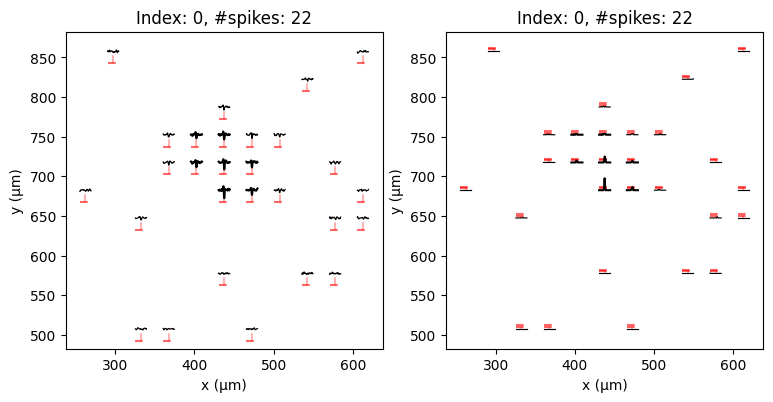

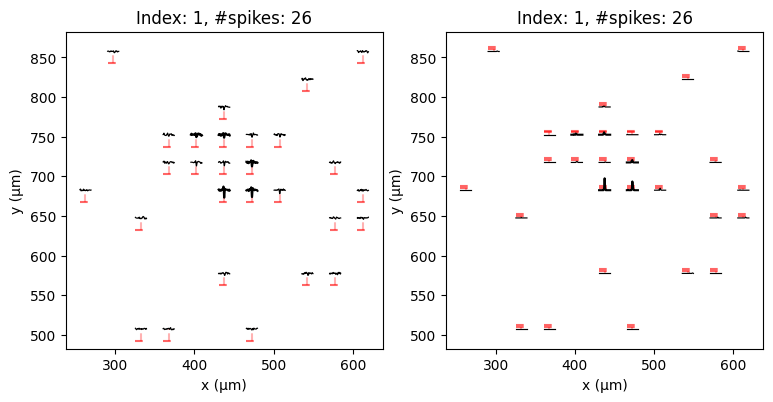

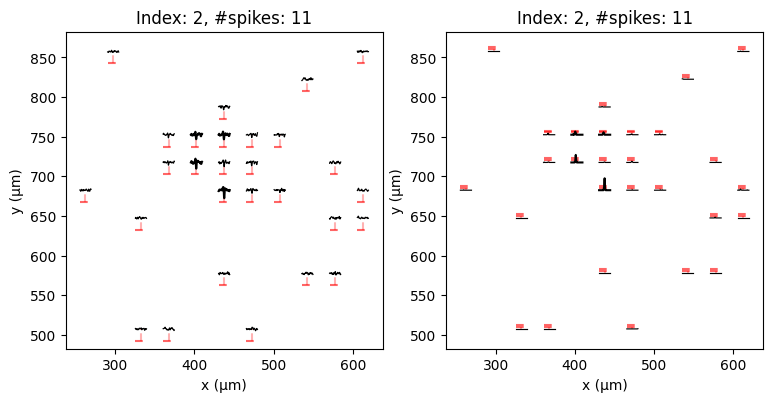

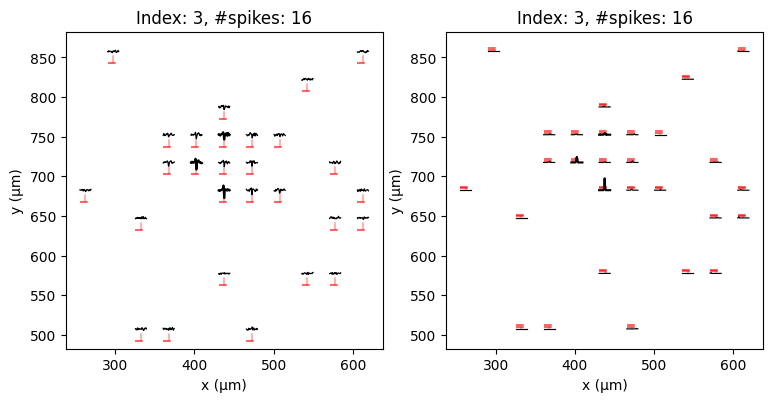

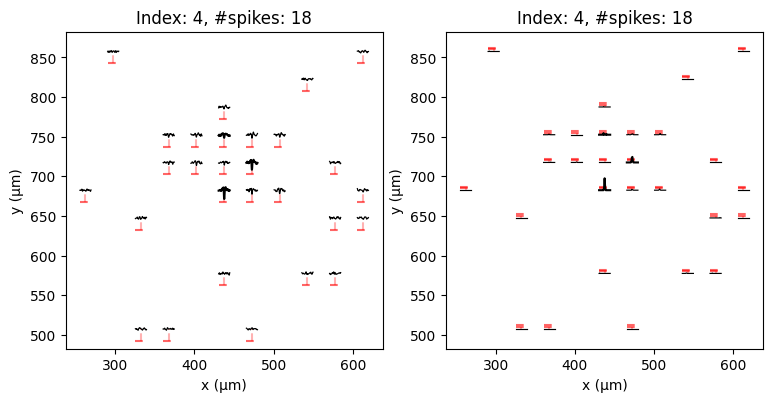

In [20]:
for i, cluster in enumerate(coc_clusters):  
    F.plot_elec_probs(cluster, idx=i)
    plt.show()
    
    # amp_medians = F.get_amp_medians(cluster, n_cocs=None)
    # plt.hist(amp_medians, bins=30)
    # plt.show()


In [ ]:
## Examine merge scores of seq pair

cluster_i = merged_clusters[0]
cluster_j = merged_clusters[2]

total_loose = len(set(cluster_i.loose_elecs).union(cluster_j.loose_elecs))
num_loose_overlaps = len(set(cluster_i.loose_elecs).intersection(cluster_j.loose_elecs))
print(f"Elec overlap: {num_loose_overlaps / total_loose:.2f}")

i_comp_elecs = cluster_i.comp_elecs
i_comp_elecs_set = set(i_comp_elecs)
j_comp_elecs = cluster_j.comp_elecs
comp_elecs = i_comp_elecs + [elec for elec in j_comp_elecs if elec not in i_comp_elecs_set]  # Prevents counting an elec more than once

# Get elec probs
i_elec_probs = cluster_i.all_elec_probs[comp_elecs]
j_elec_probs = cluster_j.all_elec_probs[comp_elecs]

# Compare latencies
i_latencies = cluster_i.all_latencies[comp_elecs][1:]
j_latencies = cluster_j.all_latencies[comp_elecs][1:]
elec_weights = F.get_elec_weights(i_elec_probs, j_elec_probs, for_latencies=True)
latency_diff = np.sum(np.abs(i_latencies - j_latencies) * elec_weights)
print(f"Latency diff: {latency_diff:.2f}")

i_amp_medians = cluster_i.all_amp_medians[comp_elecs]
j_amp_medians = cluster_j.all_amp_medians[comp_elecs]                
elec_weights = F.get_elec_weights(i_elec_probs, j_elec_probs, for_latencies=False)
amp_median_div = (i_amp_medians + j_amp_medians) / 2
amp_median_diff = np.abs((i_amp_medians - j_amp_medians)) / amp_median_div
amp_median_diff = np.sum(amp_median_diff * elec_weights)
print(f"Amp diff : {amp_median_diff:.2f}")

for root_elec in set(cluster_i.root_elecs + cluster_j.root_elecs):
    root_amps_i = cluster_i.every_amp_median[root_elec, :] # get_amp_medians(cluster_i, root_elec=root_elec)
    root_amps_j = cluster_j.every_amp_median[root_elec, :] # get_amp_medians(cluster_j, root_elec=root_elec)
    dip, pval = diptest(np.concatenate([root_amps_i, root_amps_j]))
    print(f"Elec {root_elec} p-val: {pval:.2f}")

Elec overlap: 0.92
Latency diff: 0.42
Amp diff : 0.33
Elec 17 p-val: 1.00


In [ ]:
F.setup_coc_clusters(merges)
pair = F.Merge(merges[0], merges[1])
pair.summarize()

Latency diff: 1.16. Rel amp diff: 0.33
Amp dist p-value 0.0541


#### Figure finding
Find example of bimodal latency distribution between root elec and comparison elec

Starting with elec 1, loc: [59. 40.]

Finding coocurrences


  0%|          | 0/12163 [00:00<?, ?it/s]

100%|██████████| 12163/12163 [00:02<00:00, 4460.07it/s]


3518 cocs total

Unimodal amp/median with p-value: 0.995

Comparing to elec 3, loc: [43. 60.]


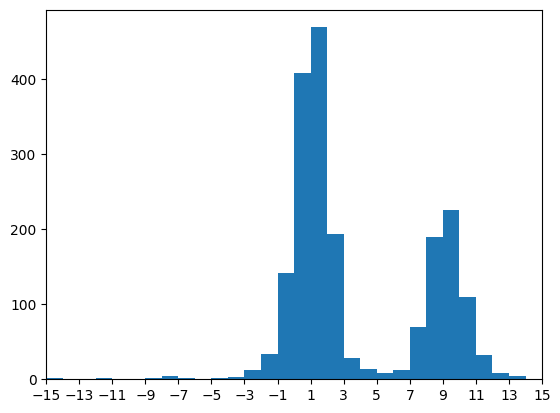

AssertionError: 

In [ ]:
clusters = F.form_coc_clusters(1, TRAINING_MS, verbose=True)

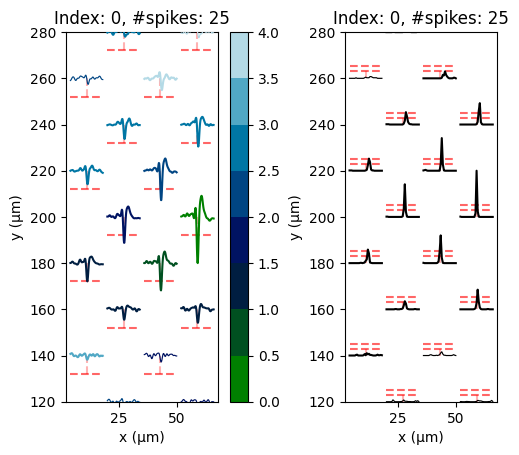

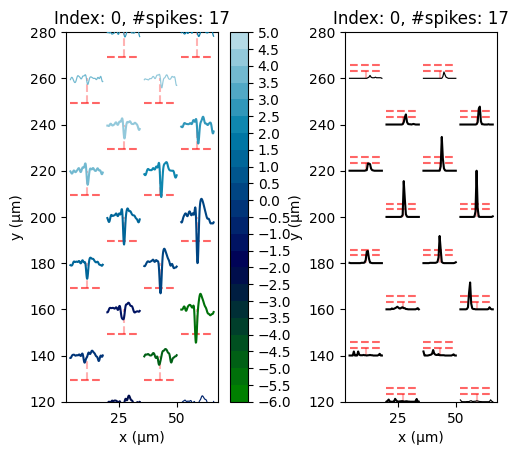

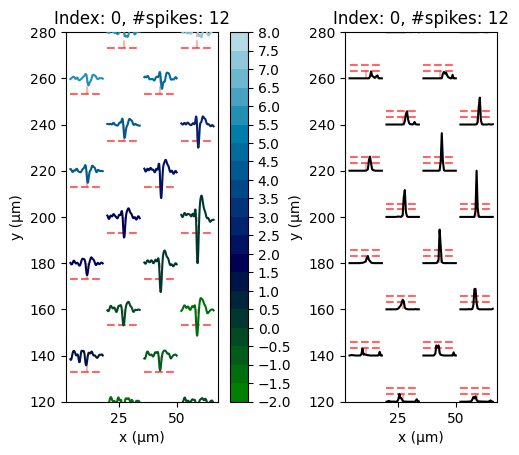

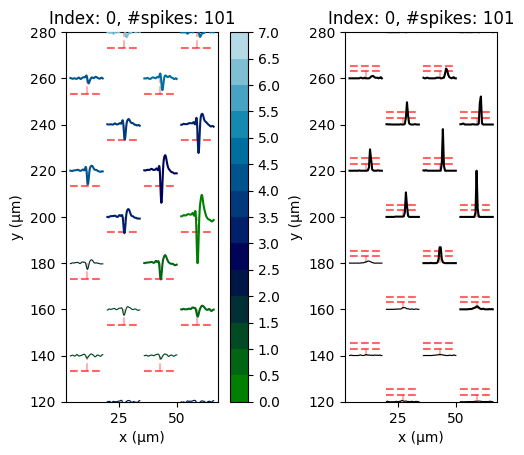

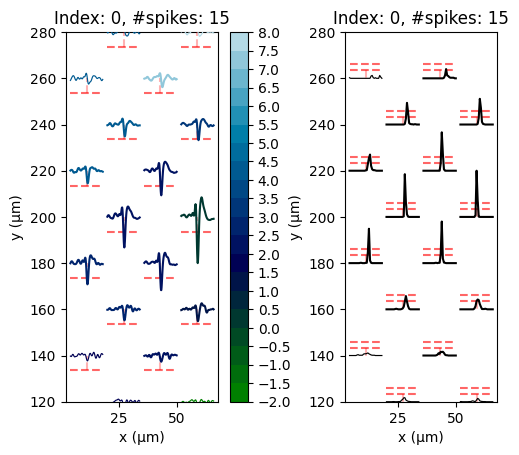

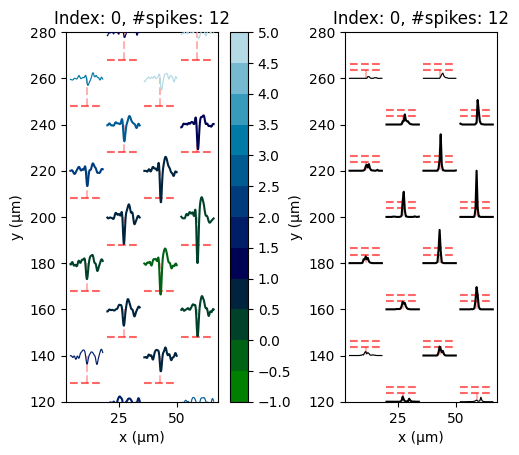

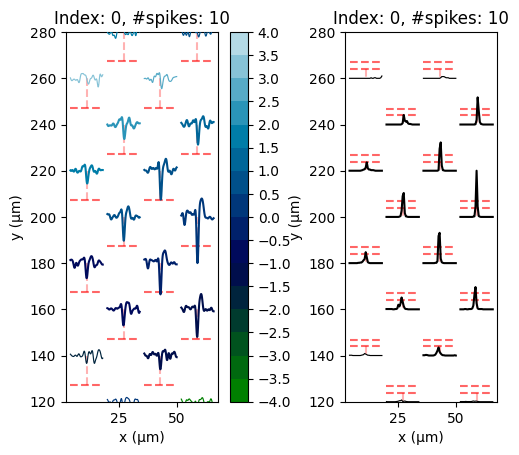

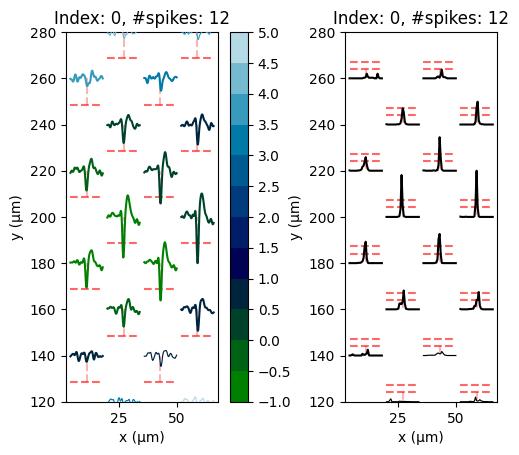

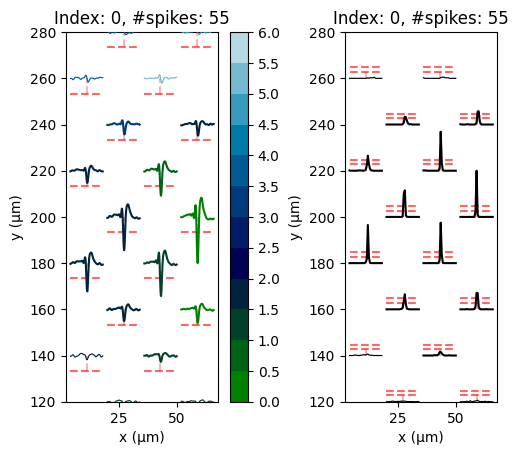

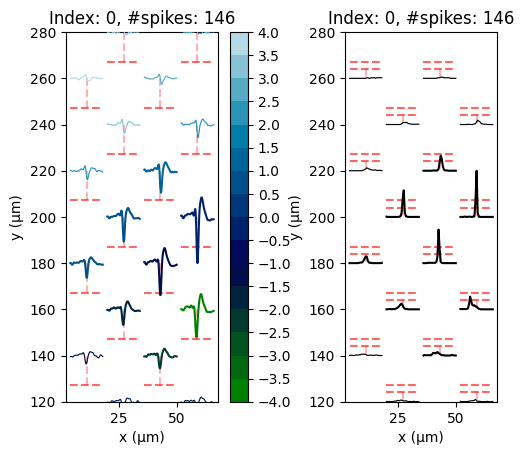

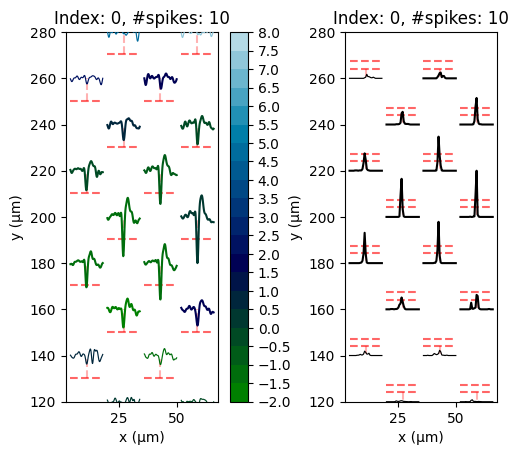

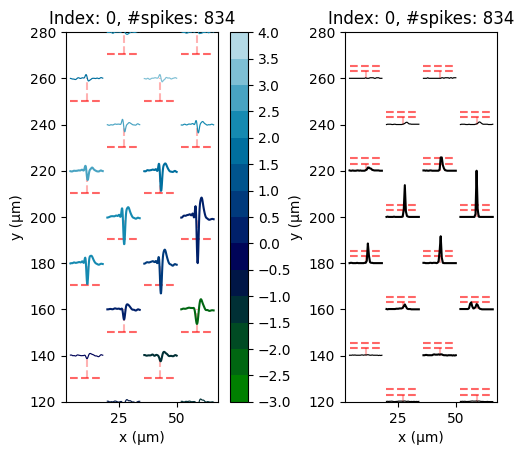

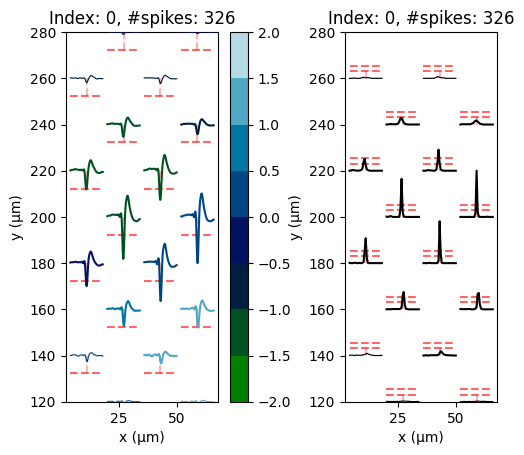

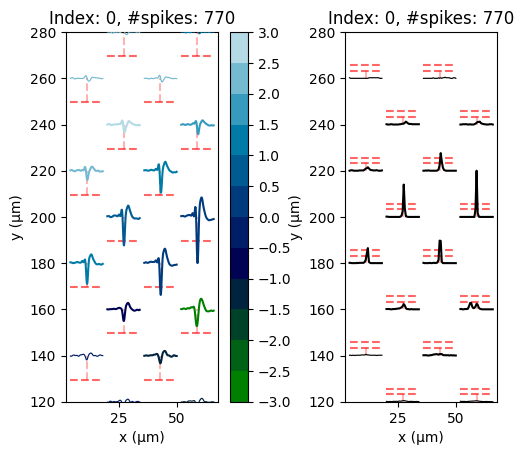

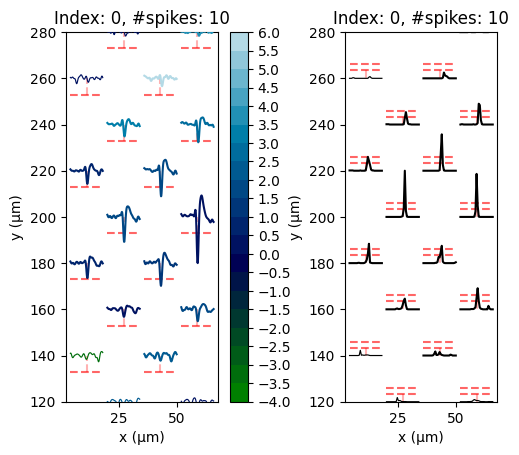

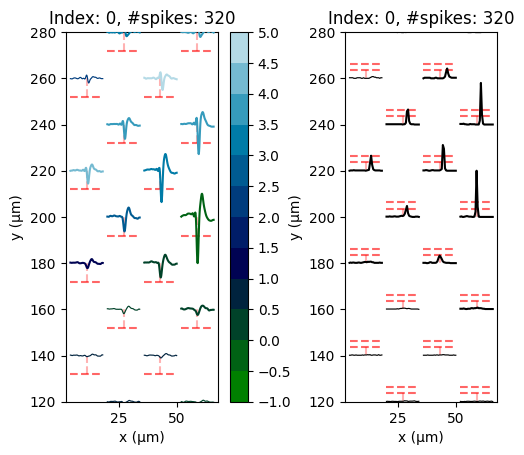

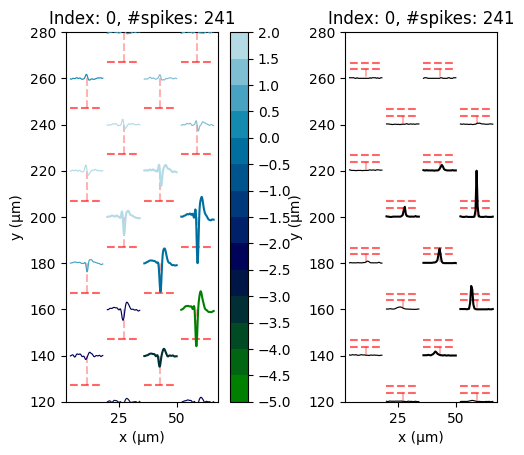

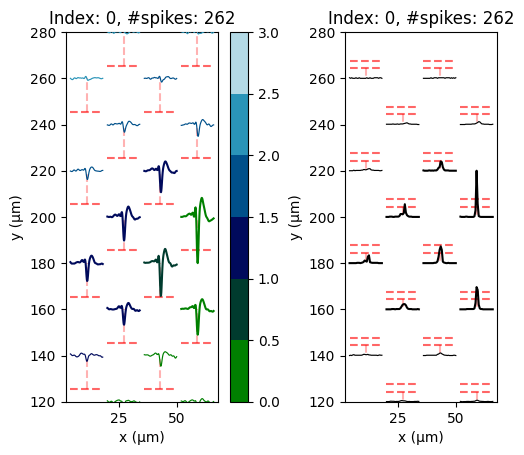

In [ ]:
for cluster in clusters:
    F.plot_elec_probs(cluster)
    plt.show()

### Full run

In [16]:
ROOT_PATH = Path("/data/MEAprojects/primary_mouse/tau/231111/22283/Network/000157/rt_sort/231227")

MAX_LATENCY_DIFF = 2.51
MAX_AMP_MEDIAN_DIFF = 0.35

MIN_SPIKES = 0.05 * (TRAINING_MS[1] - TRAINING_MS[0]) / 1000

In [12]:
def job(root_elec):
    merges = F.form_from_root(root_elec, TRAINING_MS,
                  max_latency_diff=MAX_LATENCY_DIFF, max_amp_median_diff=MAX_AMP_MEDIAN_DIFF)
    return merges
  
np.random.seed(1150)
all_sequences = []
with Pool(processes=20) as pool:
    for sequences in tqdm(pool.imap_unordered(job, range(NUM_ELECS)), total=NUM_ELECS):
        all_sequences += sequences
for idx, seq in enumerate(all_sequences):
    seq.idx = idx
all_sequences_before_inter = deepcopy(all_sequences)
print(f"{len(all_sequences)} sequences before interelec merging")

  1%|          | 10/1020 [00:28<1:08:54,  4.09s/it]/data/MEAprojects/PropSignal/src/run_alg/si_rec9.py:803: RuntimeWarning: invalid value encountered in true_divide
  amp_medians = amps / pre_medians
  1%|▏         | 15/1020 [00:47<1:03:04,  3.77s/it]/data/MEAprojects/PropSignal/src/run_alg/si_rec9.py:803: RuntimeWarning: invalid value encountered in true_divide
  amp_medians = amps / pre_medians
  3%|▎         | 30/1020 [01:17<33:10,  2.01s/it]  /data/MEAprojects/PropSignal/src/run_alg/si_rec9.py:803: RuntimeWarning: invalid value encountered in true_divide
  amp_medians = amps / pre_medians
  3%|▎         | 35/1020 [01:46<1:21:24,  4.96s/it]/data/MEAprojects/PropSignal/src/run_alg/si_rec9.py:803: RuntimeWarning: invalid value encountered in true_divide
  amp_medians = amps / pre_medians
  4%|▎         | 36/1020 [02:01<2:08:17,  7.82s/it]/data/MEAprojects/PropSignal/src/run_alg/si_rec9.py:803: RuntimeWarning: invalid value encountered in true_divide
  amp_medians = amps / pre_medians


407 sequences before interelec merging


In [14]:
utils.pickle_dump(all_sequences, ROOT_PATH / "all_sequences.pickle")

In [15]:
all_sequences = utils.pickle_load(ROOT_PATH / "all_sequences.pickle")

In [19]:
merged_sequences = utils.pickle_load(ROOT_PATH / "all_sequences.pickle")  # deepcopy(all_sequences)
merged_sequences = F.merge_coc_clusters(merged_sequences, max_latency_diff=MAX_LATENCY_DIFF, max_amp_median_diff=MAX_AMP_MEDIAN_DIFF,
                                        auto_setup_coc_clusters=False, 
                                        verbose=True)


Merged 187 with 317
Latency diff: 0.34. Amp median diff: 0.13
Amp dist p-value 0.3983
#spikes:
Merge base: 49, Add: 214, Overlaps: 0
After merging: 263

Merged 29 with 100
Latency diff: 0.30. Amp median diff: 0.13
Amp dist p-value 0.9811
#spikes:
Merge base: 165, Add: 209, Overlaps: 0
After merging: 374

Merged 5 with 78
Latency diff: 0.26. Amp median diff: 0.15
Amp dist p-value 0.6541
#spikes:
Merge base: 47, Add: 258, Overlaps: 0
After merging: 305

Merged [187, 317] with 316
Latency diff: 0.83. Amp median diff: 0.08
Amp dist p-value 0.1504
#spikes:
Merge base: 263, Add: 738, Overlaps: 0
After merging: 1001

Merged 111 with 143
Latency diff: 0.25. Amp median diff: 0.17
Amp dist p-value 0.8324
#spikes:
Merge base: 27, Add: 124, Overlaps: 0
After merging: 151

Merged 17 with 33
Latency diff: 0.22. Amp median diff: 0.17
Amp dist p-value 0.4864
#spikes:
Merge base: 58, Add: 214, Overlaps: 0
After merging: 272

Merged 87 with 183
Latency diff: 0.25. Amp median diff: 0.17
Amp dist p-value

In [20]:
utils.pickle_dump(merged_sequences, ROOT_PATH / "merged_sequences.pickle")

In [21]:
merged_sequences = utils.pickle_load(ROOT_PATH / "merged_sequences.pickle")

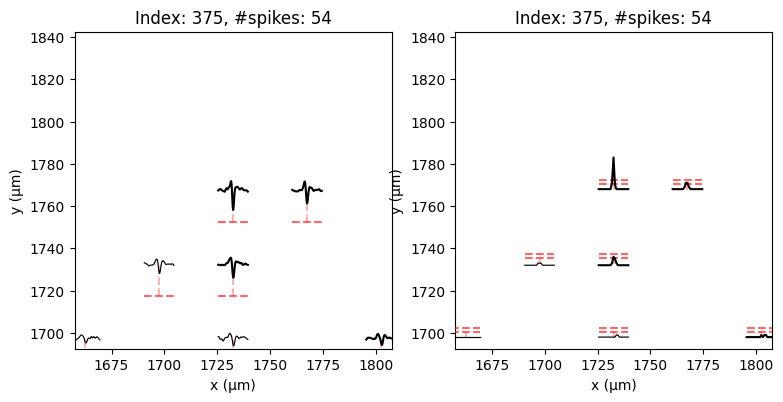

In [23]:
# for cluster in merged_sequences:
#     F.plot_elec_probs(cluster)
#     plt.show()

# Look at sequences in merge
F.plot_elec_probs(merged_sequences[345])
plt.show()

# for idx in [400, 401, 458, 411, 410, 461, 419, 486, 489]:
#     F.plot_elec_probs(all_sequences[idx])
#     plt.show()

In [11]:
final_sequences = []
idx = 0
for seq in utils.pickle_load(ROOT_PATH / "merged_sequences.pickle"): # deepcopy(merged_sequences):
    if len(seq._spike_train) >= MIN_SPIKES:
        seq.idx = idx
        final_sequences.append(seq)
        idx += 1
assert False, "do not curate before reassigning spikes"
print(f"{len(final_sequences)} sequences after interelec merging")

# Without parallel processing
F.assign_spikes(final_sequences, TESTING_MS, interelec=True, only_max_amps=False,
                max_latency_diff=MAX_LATENCY_DIFF, max_amp_median_diff=MAX_AMP_MEDIAN_DIFF,
                verbose=True,
                overlap_time=0.1)
final_sequences = [seq for seq in final_sequences if len(seq._spike_train) >= MIN_SPIKES]
print(f"{len(final_sequences)} sequences after final spike assignment")

# With parallel processing (this needs an additional function to handle spike splitting)
# def job(seq):
#     F.assign_spikes([seq], TESTING_FRAMES, interelec=False, only_max_amps=False,
#                     max_latency_diff=MAX_LATENCY_DIFF, max_amp_median_diff=MAX_AMP_MEDIAN_DIFF,
#                     verbose=True,
#                     overlap_time=0.1)
#     return seq

# final_sequences_with_spikes = []
# with Pool(processes=20) as pool:
#     for seq in tqdm(pool.imap_unordered(job, final_sequences), total=len(final_sequences)):
#         final_sequences_with_spikes.append(seq)
# final_sequences_with_spikes = sorted(final_sequences_with_spikes, key=lambda seq: seq.idx)

71 sequences after interelec merging


100%|██████████| 9334268/9334268 [12:08<00:00, 12815.56it/s]

51 sequences after final spike assignment


In [12]:
utils.pickle_dump(final_sequences, ROOT_PATH / "final_sequences.pickle")

In [13]:
prop_signal = F.clusters_to_sorter(final_sequences)
prop_signal.recording = None
utils.pickle_dump(prop_signal, ROOT_PATH / "prop_signal.pickle")  # Still called prop_signal since called prop_signal in old scripts

In [5]:
final_sequences = utils.pickle_load(ROOT_PATH / "final_sequences.pickle")
all_spike_times = [seq.spike_train for seq in final_sequences]
np.save(ROOT_PATH/"all_spike_times.npy", all_spike_times)

In [ ]:
F.plot_elec_probs(final_sequences[20])
plt.show()

In [14]:
final_sequences = utils.pickle_load(ROOT_PATH / "final_sequences.pickle")  # Might need to reload sequences if error about not being able to pickle class is raised
F.save_sequences_plots(final_sequences, ROOT_PATH  / "sequence_footprints")

  0%|          | 0/51 [00:00<?, ?it/s]/data/MEAprojects/PropSignal/src/run_alg/si_rec9.py:272: RuntimeWarning: invalid value encountered in true_divide
  window = (window - means) / medians
/data/MEAprojects/PropSignal/src/run_alg/si_rec9.py:272: RuntimeWarning: invalid value encountered in true_divide
  window = (window - means) / medians
/data/MEAprojects/PropSignal/src/run_alg/si_rec9.py:272: RuntimeWarning: invalid value encountered in true_divide
  window = (window - means) / medians
/data/MEAprojects/PropSignal/src/run_alg/si_rec9.py:272: RuntimeWarning: invalid value encountered in true_divide
  window = (window - means) / medians
/data/MEAprojects/PropSignal/src/run_alg/si_rec9.py:272: RuntimeWarning: invalid value encountered in true_divide
  window = (window - means) / medians
/data/MEAprojects/PropSignal/src/run_alg/si_rec9.py:272: RuntimeWarning: invalid value encountered in true_divide
  window = (window - means) / medians
/data/MEAprojects/PropSignal/src/run_alg/si_rec9.p

### Testing

In [ ]:
# For testing concatenated spike trains
# spike_times = set()
# for seq in final_sequences:
#     spike_times.update(seq._spike_train)
# spike_times = np.sort(list(spike_times))
# np.save("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231128/overlap_time_0.0_no_interelec.npy", spike_times)

# utils.pickle_dump(final_sequences, "/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231128/final_sequences_test_0.0.pickle")
# final_sequences = utils.pickle_load("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231128/final_sequences_test.pickle")

In [ ]:
# for idx in [170, 179, 180, 181, 183, 186, 190, 189, 191, 187]:
#     F.plot_elec_probs(all_sequences[idx])
#     plt.show()

cluster_i = all_sequences[170]
cluster_j = all_sequences[180]

F.plot_elec_probs(cluster_i)
plt.show()

F.plot_elec_probs(cluster_j)
plt.show()

elecs = cluster_i.elecs
                
# Compare latencies
elec_weights = F.get_elec_weights(cluster_i.elec_probs, cluster_j.all_elec_probs[elecs], for_latencies=True)
latency_diff = np.sum(np.abs(cluster_i.latencies - cluster_j.all_latencies[elecs[1:]]) * elec_weights)
print(latency_diff)

elec_weights = F.get_elec_weights(cluster_i.elec_probs, cluster_j.all_elec_probs[elecs], for_latencies=False)
cluster_j_amp_medians = cluster_j.all_amp_medians[elecs]
amp_median_div = (cluster_i.amp_medians + cluster_j_amp_medians) / 2
amp_median_diff = np.abs((cluster_i.amp_medians - cluster_j_amp_medians)) / amp_median_div
amp_median_diff = np.sum(amp_median_diff * elec_weights)
print(amp_median_diff)

0.8140128363575329
0.20346771


### Manual threshold tuning

In [ ]:
MAX_LATENCY_DIFF = 2.51
MAX_AMP_MEDIAN_DIFF = 0.35
MIN_INNER_COCS = 0
MIN_OUTER_COCS = 0

MIN_SPIKES = 0.05 * 300 # Based on HZ

def job(root_elec):
    merges = F.form_from_root(root_elec, TRAINING_MS,
                  max_latency_diff=MAX_LATENCY_DIFF, max_amp_median_diff=MAX_AMP_MEDIAN_DIFF,
                  min_inner_cocs=MIN_INNER_COCS, min_outer_cocs=MIN_OUTER_COCS)
    return merges


for inner, outer in [(0, 0), (1, 2), (1, 3), (2, 3), (2, 4)]:
    MIN_INNER_COCS = inner
    MIN_OUTER_COCS = outer
  
    try:
        all_sequences = []
        with Pool(processes=20) as pool:
            for sequences in tqdm(pool.imap_unordered(job, range(NUM_ELECS)), total=NUM_ELECS):
                all_sequences += sequences
        for idx, seq in enumerate(all_sequences):
            seq.idx = idx
        all_sequences_before_inter = deepcopy(all_sequences)
        print(f"{len(all_sequences)} sequences before interelec merging")
            
        try:  
            all_sequences = F.merge_coc_clusters(all_sequences, max_latency_diff=MAX_LATENCY_DIFF, max_amp_median_diff=MAX_AMP_MEDIAN_DIFF,
                                                auto_setup_coc_clusters=False, verbose=True)
            final_sequences = []
            idx = 0
            for seq in all_sequences:
                if len(seq._spike_train) >= MIN_SPIKES:
                    seq.idx = idx
                    final_sequences.append(seq)
                    idx += 1
            print(f"{len(final_sequences)} sequences after interelec merging")
        
            F.assign_spikes(final_sequences, TESTING_MS, interelec=True, only_max_amps=False,
                            max_latency_diff=MAX_LATENCY_DIFF, max_amp_median_diff=MAX_AMP_MEDIAN_DIFF,
                            min_inner_cocs=MIN_INNER_COCS, min_outer_cocs=MIN_OUTER_COCS, 
                            verbose=True)
            addon = ""
        except:
            final_sequences = all_sequences_before_inter
            addon = "_before_interelec_merging"
    
        F.save_sequences_plots(final_sequences, Path(f"/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231127/{inner}_{outer}{addon}"))
    except:
        pass

# all_sequences = []
# with Pool(processes=20) as pool:
#     for sequences in tqdm(pool.imap_unordered(job, range(NUM_ELECS)), total=NUM_ELECS):
#         all_sequences += sequences
# all_sequences = F.merge_coc_clusters(all_sequences, max_latency_diff=MAX_LATENCY_DIFF, max_amp_median_diff=MAX_AMP_MEDIAN_DIFF,
#                                      auto_setup_coc_clusters=False)
# final_sequences = []
# idx = 0
# for seq in all_sequences:
#     if len(seq._spike_train) >= MIN_SPIKES:
#         seq.idx = idx
#         final_sequences.append(seq)
#         idx += 1

# F.assign_spikes(final_sequences, TESTING_FRAMES, interelec=True, only_max_amps=False,
#                 max_latency_diff=MAX_LATENCY_DIFF, max_amp_median_diff=MAX_AMP_MEDIAN_DIFF,
#                   min_inner_cocs=MIN_INNER_COCS, min_outer_cocs=MIN_OUTER_COCS)


# F.save_sequences_plots(final_sequences, )


# Because using imap (instead of imap_unordered), the progress bar freezes (for elecs with many cocs/clusters)
# it then jumps rapidly to the end 

In [ ]:
F.save_sequences_plots(all_sequences, Path(f"/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231127/{inner}_{outer}"))


  0%|          | 0/477 [00:00<?, ?it/s]

 11%|█▏        | 54/477 [01:27<11:26,  1.62s/it]Process ForkPoolWorker-219:
Process ForkPoolWorker-218:
Process ForkPoolWorker-210:
Process ForkPoolWorker-212:
Process ForkPoolWorker-217:
Process ForkPoolWorker-205:
Process ForkPoolWorker-214:
Process ForkPoolWorker-215:
Process ForkPoolWorker-203:
Process ForkPoolWorker-209:
Process ForkPoolWorker-208:
Traceback (most recent call last):
Process ForkPoolWorker-204:
  File "/home/mea/anaconda3/envs/prop/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mea/anaconda3/envs/prop/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/mea/anaconda3/envs/prop/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Process ForkPoolWorker-

KeyboardInterrupt: 

In [ ]:
all_sequences = F.clusters_to_clusters(all_sequences)

In [ ]:
# utils.pickle_dump(all_sequences, "/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231107/all_sequences_dip_test.pickle")
all_sequences = utils.pickle_load("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231107/all_sequences_dip_test.pickle")    
# all_sequences = F.setup_coc_clusters_parallel(all_sequences)

In [ ]:
all_spike_times_curated = []
for seq in all_sequences:
    all_spike_times_curated.extend(seq.spike_train)
all_spike_times_curated = np.sort(all_spike_times_curated)

matches = Comparison.count_matching_events(all_spike_times_curated, ks_spikes)
print(f"#matches/#rt_sort: {matches/len(all_spike_times_curated)*100:.1f}")
print(f"#matches/#kilosort: {matches/len(ks_spikes)*100:.1f}")

#matches/#rt_sort: 46.2
#matches/#kilosort: 87.8


In [ ]:
all_merged_sequences = F.merge_coc_clusters(all_sequences, max_root_elec_dist=50,
                                            auto_setup_coc_clusters=False,
                                            verbose=True)


Merged 140 with 143
Latency diff: 0.03. Rel amp diff: 0.00
Amp dist p-value 0.9544
#spikes:
Merge base: 2341, Add: 2184, Overlaps: 1
After merging: 2397

Merged 119 with 122
Latency diff: 0.14. Rel amp diff: 0.01
Amp dist p-value 1.0000
#spikes:
Merge base: 3087, Add: 3193, Overlaps: 0
After merging: 3317

Merged 272 with 275
Latency diff: 0.07. Rel amp diff: 0.02
Amp dist p-value 1.0000
#spikes:
Merge base: 1747, Add: 2823, Overlaps: 460
After merging: 3277

Merged 134 with 138
Latency diff: 0.13. Rel amp diff: 0.03
Amp dist p-value 0.8204
#spikes:
Merge base: 677, Add: 559, Overlaps: 9
After merging: 1029

Merged 283 with 286
Latency diff: 0.00. Rel amp diff: 0.06
Amp dist p-value 0.9942
#spikes:
Merge base: 2617, Add: 1256, Overlaps: 74
After merging: 2760

Merged 171 with 176
Latency diff: 0.11. Rel amp diff: 0.05
Amp dist p-value 0.9964
#spikes:
Merge base: 3158, Add: 1585, Overlaps: 5
After merging: 3557

Merged 218 with 222
Latency diff: 0.00. Rel amp diff: 0.07
Amp dist p-valu

In [ ]:
# utils.pickle_dump(all_merged_sequences, "/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231107/all_merged_sequences_dip_test.pickle")

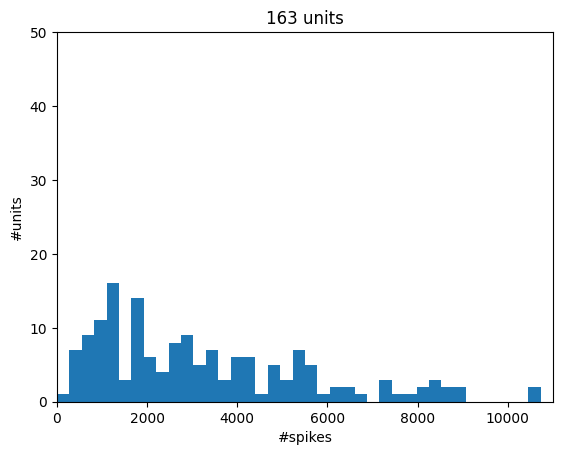

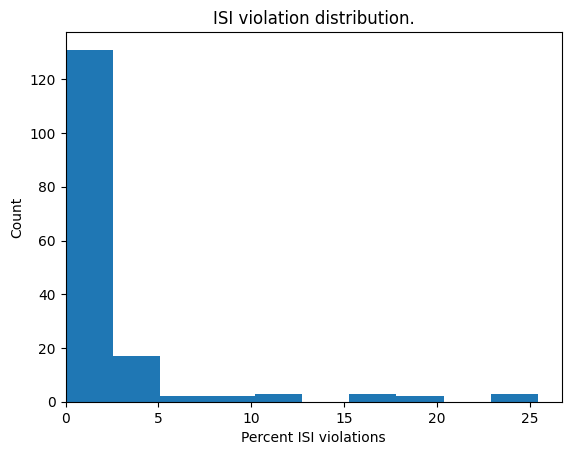

In [ ]:
prop_signal = F.clusters_to_sorter(all_merged_sequences)
prop_signal.plot_nums_spikes()
plt.show()
prop_signal.plot_isis()
plt.show()

100%|██████████| 163/163 [00:09<00:00, 16.92it/s]


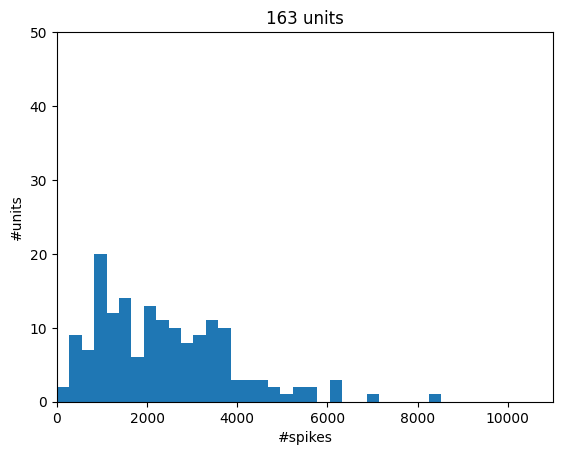

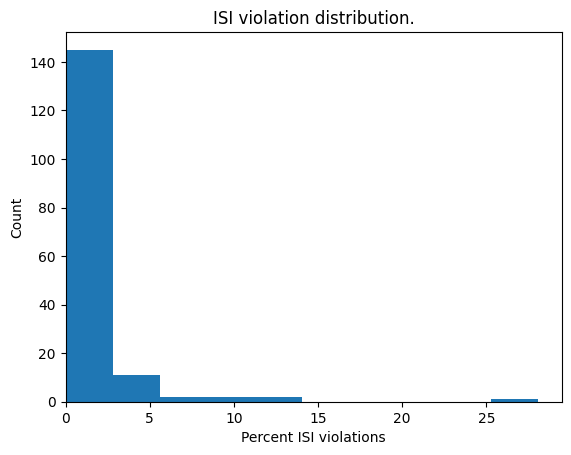

In [ ]:
# This probably isn't needed (maybe it is though)
F.assign_spikes(all_merged_sequences, TRAINING_MS, interelec=True,
                overlap_time=0.1, verbose=True)
all_merged_sequences = F.setup_coc_clusters_parallel(F.clusters_to_clusters(all_merged_sequences))
prop_signal = F.clusters_to_sorter(all_merged_sequences)
prop_signal.plot_nums_spikes()
plt.show()
prop_signal.plot_isis()
plt.show()

### Further development

In [ ]:
for s, seq in enumerate(all_trained_sequences):
    # If seq is Unit obj
    seq.recording = RECORDING
    seq.root_elecs = [seq.chan]
    seq._spike_train = seq.spike_train
    
    isi = F.get_isi_viol_p(seq)
    if isi > 20:
        print(s)
        
        F.plot_elec_probs(seq, idx=s)
        plt.show()
        
        F.plot_amp_dist(seq, bins=40)
        plt.show()
        
        print(F.get_isi_viol_p(seq))

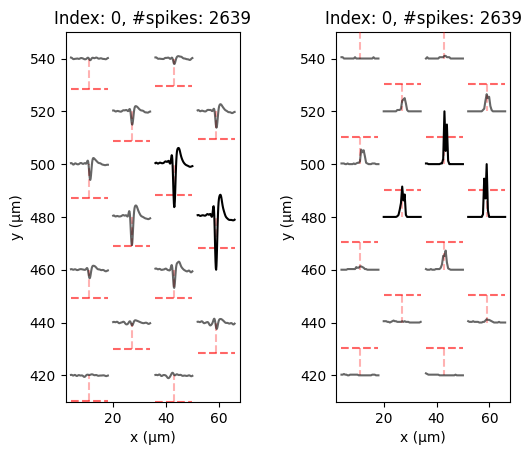

2630


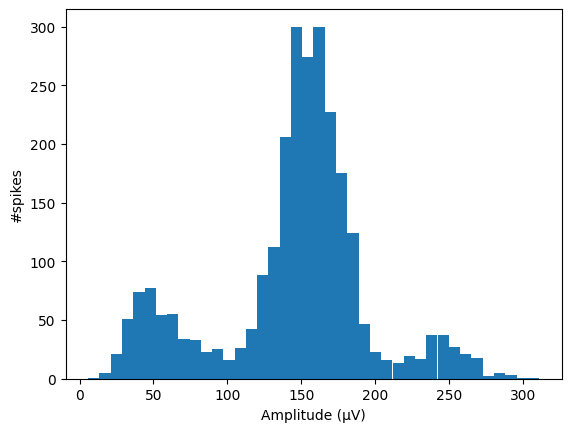

31.527093596059114


In [ ]:
isi_violators = [cluster for cluster in all_trained_sequences if F.get_isi_viol_p(cluster) > 2]
for s, cluster in enumerate(isi_violators):
    if F.get_isi_viol_p(cluster) > 30:
        F.plot_elec_probs(cluster)
        plt.show()
        
        F.plot_amp_dist(cluster, bins=40)
        plt.show()
        
        print(F.get_isi_viol_p(cluster))
        
        break


In [ ]:
for idx in cluster.merge_history:
    clust = all_sequences[idx]
    F.plot_split_amp(clust, 100)
        
    # F.plot_elec_probs(clust)
    # plt.show()
    # F.plot_amp_dist(clust, bins=40)
    # plt.show()
    # print(F.get_isi_viol_p(clust))
    break

## Assign spikes in test region

In [ ]:
F.assign_spikes(all_merged_sequences, TESTING_MS, interelec=True,
                overlap_time=0.1,
                verbose=True)

100%|██████████| 2227701/2227701 [07:54<00:00, 4696.73it/s]


### Further development

In [ ]:
for s, seq in enumerate(all_merged_sequences):
    # If seq is Unit obj
    # seq.recording = RECORDING
    # seq.root_elecs = [seq.chan]
    # seq._spike_train = seq.spike_train
    
    isi = F.get_isi_viol_p(seq)
    if isi > 2:
        isis = np.diff(seq.spike_train)
        plt.hist(isis, bins=40, range=(0, 5))
        plt.xlim(0, 5)
        plt.show()
        
        
        
        # F.plot_elec_probs(seq, idx=s)
        # plt.show()
        
        # F.plot_amp_dist(seq, bins=40)
        # plt.show()
        
        # print(F.get_isi_viol_p(seq))

In [ ]:
for seq in all_merged_sequences:
    F.plot_elec_probs(seq)
    plt.show()

## Save to file

In [ ]:
prop_signal = F.clusters_to_sorter(all_merged_sequences)
prop_signal.recording = None
utils.pickle_dump(prop_signal, "/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231107/2.pickle")

In [ ]:
# quick and dirty, find #overlaps
OVERLAP_TIME = 0.034

all_spikes = []
for s in all_trained_sequences:
    all_spikes.extend(s.spike_train)
all_spikes = np.sort(all_spikes)

count = 0
for i in range(1, len(all_spikes)):
    if all_spikes[i] - all_spikes[i-1] <= OVERLAP_TIME:
        count += 1
print(count)
print(count / len(all_spikes) * 100)

25042
6.761839699953827


## Compare to kilosort
For development and testing

### Setup

In [ ]:
%autoreload 2
from src.comparison import Comparison
from src.sorters.base import SpikeSorter
from src.sorters.kilosort import get_experts_kilosort

In [ ]:
kilosort = get_experts_kilosort(testing_ms=TESTING_MS)

# Create all_ks_units with self.templates and self.chan set --> Don't run this if already ran before
all_ks_units = []

def job(idx):
    unit = Unit(idx, all_ks_spike_times[idx], -1, RECORDING)
    templates = unit.get_templates()
    unit.templates = templates
    unit.recording = None
    unit.chan = np.argmin(np.min(templates, axis=1))
    unit.root_elecs = [unit.chan]
    return unit

all_ks_spike_times = kilosort.get_spike_times()
with Pool(processes=20) as pool:
    tasks = range(len(all_ks_spike_times))
    for unit in tqdm(pool.imap(job, tasks), total=len(tasks)):
        unit.recording = RECORDING
        all_ks_units.append(unit)
        
chan_to_ks_units = {}
for unit in all_ks_units:
    if unit.chan not in chan_to_ks_units:
        chan_to_ks_units[unit.chan] = [unit]
    else:
        chan_to_ks_units[unit.chan].append(unit)

/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/hdmf/spec/namespace.py:456: UserWarning: ignoring namespace 'hdmf-common' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])
/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/hdmf/spec/namespace.py:456: UserWarning: ignoring namespace 'core' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])
/data/MEAprojects/PropSignal/src/sorters/kilosort.py:186: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spike_times = np.array([spikes1[idx] for idx in range(len(comp.match12)) if comp.match12[idx] != -1])


Recording does not have scaled traces. Setting gain to 0.195


100%|██████████| 226/226 [05:07<00:00,  1.36s/it]


In [ ]:
chan_to_prop_units = {}
for unit in final_sequences:
    for chan in unit.root_elecs:
        if chan not in chan_to_prop_units:
            chan_to_prop_units[chan] = [unit]
        else:
            chan_to_prop_units[chan].append(unit)

### Start comparing

In [ ]:
CHAN = 17

prop_units = chan_to_prop_units[CHAN]
ks_units = chan_to_ks_units[CHAN]
##
print(len(prop_units))
print(len(ks_units))

3
4


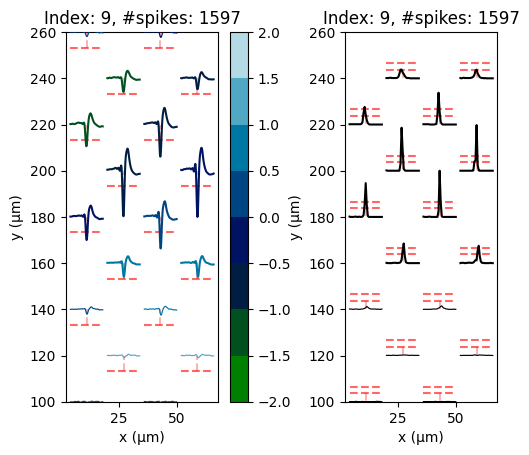

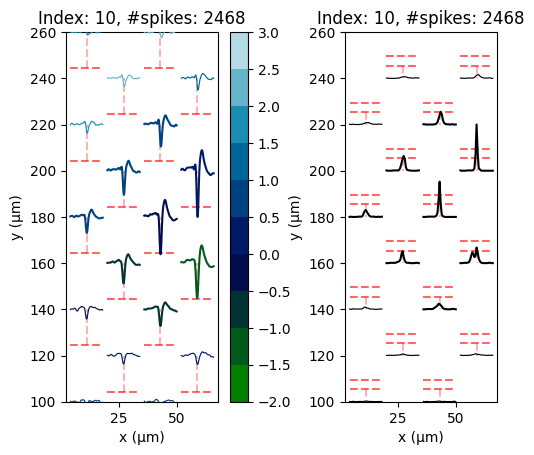

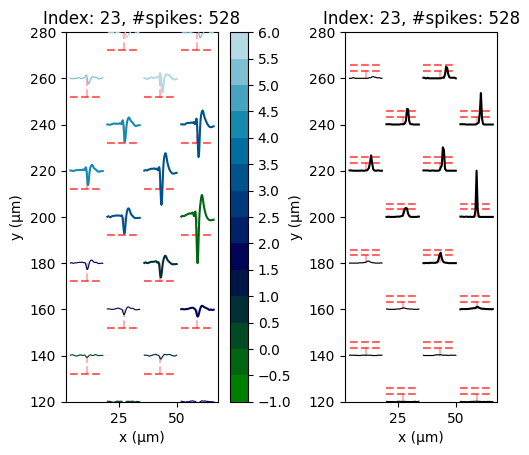

In [ ]:
for unit in prop_units:   
    amp_kwargs, prob_kwargs = F.plot_elec_probs(unit)#, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
    plt.show()

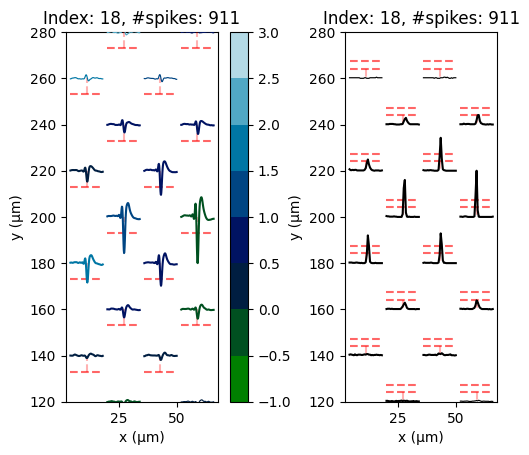

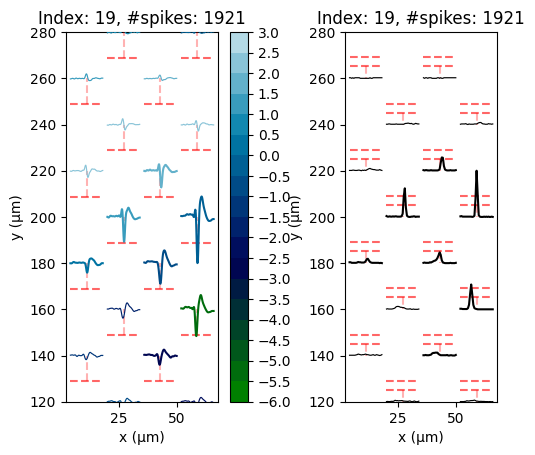

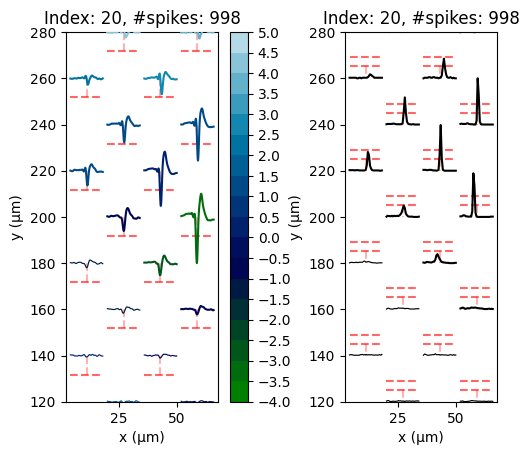

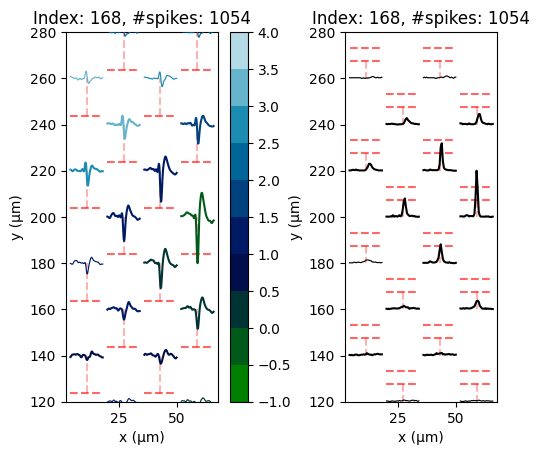

In [ ]:
for unit in ks_units:   
    amp_kwargs, prob_kwargs = F.plot_elec_probs(unit)#, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
    plt.show()

In [ ]:
all_prop_spikes = set()
for unit in final_sequences:
    all_prop_spikes.update(unit._spike_train)
all_prop_spikes = np.sort(list(all_prop_spikes))

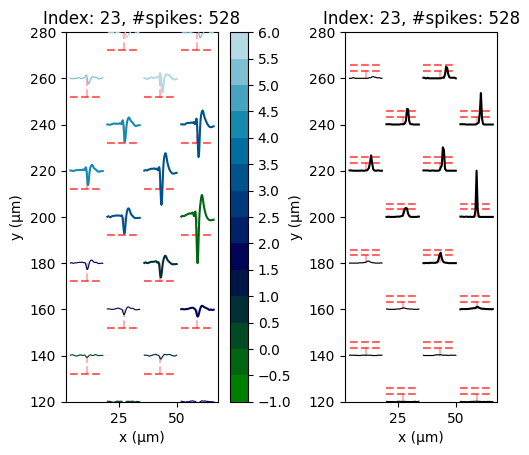

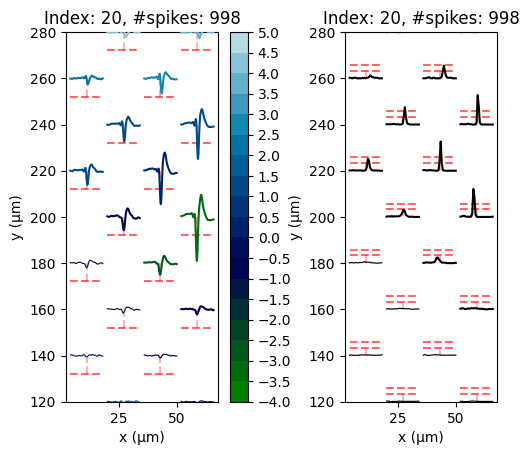

In [ ]:
prop_unit = sequence = prop_units[2]
ks_unit = ks_units[2]

amp_kwargs, prob_kwargs = F.plot_elec_probs(prop_unit)
plt.show()

F.plot_elec_probs(ks_unit, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
plt.show()

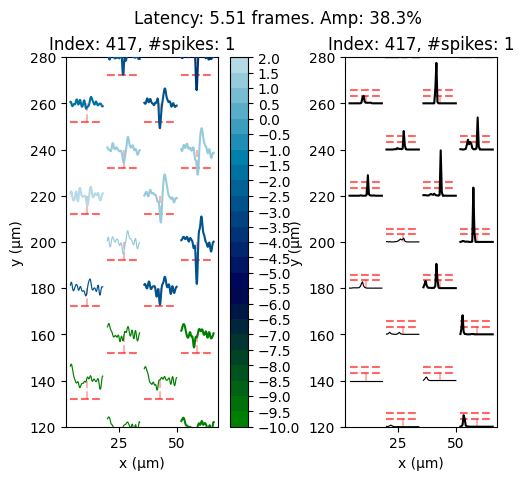

In [ ]:
np.random.seed(10)

# for spike_idx in np.random.choice(len(ks_unit.spike_train), 20, replace=False):
for spike_idx in [417]:
    time = ks_unit.spike_train[spike_idx]    

    # Check if prop detected spike
    if np.any(np.abs(all_prop_spikes - time) <= 0.4): 
        continue
    
    unit = Unit(spike_idx, [time], ks_unit.chan, RECORDING)
    F.plot_elec_probs(unit, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
    
    # region Set latency and amp diff scores in title
    n_before = n_after = 15 # 10 
    
    elecs = [unit.chan] + F.get_nearby_elecs(unit.chan)
    
    output_frame = F.rec_ms_to_output_frame(time)
    this_n_before = n_before if output_frame - n_before >= 0 else output_frame  # Prevents indexing problems
    output_window = F.OUTPUTS[:, output_frame-this_n_before:output_frame+n_after+1]
    all_elec_probs = F.sigmoid(np.max(output_window, axis=1))
    
    output_window = output_window[elecs]
    elec_probs = F.sigmoid(np.max(output_window, axis=1))
    
    latencies = np.argmax(output_window, axis=1) - this_n_before 
    
    rec_frame = round(time * SAMP_FREQ)
    amps = np.abs(F.TRACES[elecs, rec_frame + latencies])
    window_medians = F.calc_window_medians(time, elecs)  #  NOTE: This might be really slow, might be better to cache and update every X ms
    amp_medians = amps / window_medians
    
    latencies = latencies[1:]
    
    unit_elec_probs, unit_latencies, unit_amp_medians = sequence.all_elec_probs[elecs], sequence.all_latencies[elecs[1:]], sequence.all_amp_medians[elecs]
    
    elec_weights = F.get_elec_weights(unit_elec_probs, elec_probs, for_latencies=True)
    latency_diff = np.sum(np.abs(unit_latencies - latencies) * elec_weights)
    
    elec_weights = F.get_elec_weights(unit_elec_probs, elec_probs, for_latencies=False)
    amp_median_div = (unit_amp_medians + amp_medians) / 2
    amp_median_diff = np.abs((unit_amp_medians - amp_medians)) / amp_median_div
    amp_median_diff = np.sum(amp_median_diff * elec_weights)
    
    plt.suptitle(f"Latency: {latency_diff:.2f} frames. Amp: {amp_median_diff*100:.1f}%")
    
    plt.show()
    # endregion

In [ ]:
unit_elec_probs

array([0.6081915 , 0.58287376, 0.26068977, 0.3001964 , 0.58387554,
       0.11380184, 0.3526624 , 0.06465013, 0.07087522, 0.3260975 ,
       0.22613387, 0.05174522, 0.05917944, 0.03786819, 0.04209668,
       0.04788675, 0.04545609, 0.04759733], dtype=float32)

In [ ]:
elec_weights = F.get_elec_weights(unit_elec_probs, elec_probs, for_latencies=True)
latency_diff = np.sum(np.abs(unit_latencies - latencies) * elec_weights)

for elec, weight, unit_latency, latency in zip(elecs[1:], elec_weights, unit_latencies, latencies):
    print(f"{elec}: {unit_latency:.2f}, {latency:.2f}, {weight*100:.1f}%, {np.abs(unit_latency - latency)*weight*100:.1f}%")

19: 2.98, 1.00, 16.0%, 31.7%
15: 0.30, -3.00, 7.9%, 26.0%
18: 3.03, 1.00, 4.7%, 9.6%
21: 3.69, 1.00, 13.6%, 36.7%
13: 0.60, -13.00, 4.9%, 67.2%
22: 4.15, 1.00, 8.1%, 25.4%
14: 0.94, -12.00, 1.2%, 16.0%
16: 2.03, -3.00, 2.1%, 10.6%
20: 4.34, 2.00, 8.1%, 18.9%
23: 6.06, -3.00, 10.2%, 92.8%
11: 0.57, -12.00, 1.3%, 16.4%
24: 4.71, -2.00, 2.2%, 14.6%
12: 0.99, -12.00, 0.0%, 0.0%
9: 0.57, -12.00, 2.6%, 33.2%
25: 5.40, -4.00, 11.2%, 104.9%
26: 4.35, -3.00, 4.9%, 35.9%
10: 0.73, -11.00, 0.9%, 10.9%


In [ ]:
elec_weights = F.get_elec_weights(unit_elec_probs, elec_probs, for_latencies=False)
amp_median_div = (unit_amp_medians + amp_medians) / 2
amp_median_diff = np.abs((unit_amp_medians - amp_medians)) / amp_median_div
print(amp_median_diff[0])
print(amp_median_diff)
print(np.sum(amp_median_diff * elec_weights))

0.09285006
[0.09285006 0.01739845 0.42813304 0.26943627 0.29808164 1.0423726
 0.30952084 1.1683204  0.51168346 0.4498598  0.9677229  0.959181
 0.10201103 0.545433   1.1859486  1.3195163  1.0869895  0.8530344 ]
0.5253458


In [ ]:
elecs

[17, 19, 15, 18, 21, 13, 22, 14, 16, 20, 23, 11, 24, 12, 9, 25, 26, 10]

In [ ]:
unit_amp_medians

array([13.765633 ,  9.400559 ,  4.7808948,  4.7514014,  8.544403 ,
        3.2067585,  4.3976264,  2.1040976,  2.1626034,  3.9869797,
        3.6425917,  1.8296585,  1.8031704,  1.5409106,  1.6884289,
        1.9512317,  1.7849661,  1.6399273], dtype=float32)

In [ ]:
amp_medians

array([12.544198  ,  9.238415  ,  3.0949419 ,  3.6231918 , 11.537414  ,
        1.0093701 ,  6.0080066 ,  0.5523226 ,  1.2814666 ,  6.3010697 ,
       10.47219   ,  0.6435372 ,  1.9970001 ,  1.220952  ,  0.43141562,
        9.518445  ,  6.035167  ,  2.1430075 ], dtype=float32)

In [ ]:
(3.0949419-4.7808948)/3.0949419

-0.5447446040909524

In [ ]:
elec_weights

array([0.12636368, 0.12553996, 0.04689536, 0.04197321, 0.10389804,
       0.01233544, 0.09662127, 0.00712716, 0.00817499, 0.12128494,
       0.11397174, 0.        , 0.01651664, 0.        , 0.        ,
       0.08704981, 0.09224774, 0.        ], dtype=float32)

In [ ]:
rt_spikes = []
for m in merges:
    rt_spikes.extend(m.spike_train)
rt_spikes = np.sort(rt_spikes)

ks_spikes = []
for k in ks_units:
    ks_spikes.extend(k.spike_train)
ks_spikes = np.sort(ks_spikes)
    
matches = Comparison.count_matching_events(rt_spikes, ks_spikes)
print(f"#matches/#rt_sort: {matches/len(rt_spikes)*100:.1f}")
print(f"#matches/#kilosort: {matches/len(ks_spikes)*100:.1f}")

Num RT-Sort: 3
Num Kilosort: 2

1/3 matches
1/3 max matches

For RT-Sort:
Num max matches: 1
Num unique max matches: 1

For Kilosort:
Num max matches: 2
Num unique max matches: 1


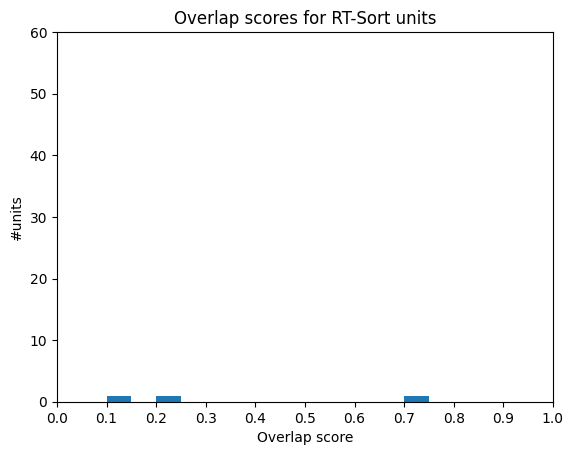

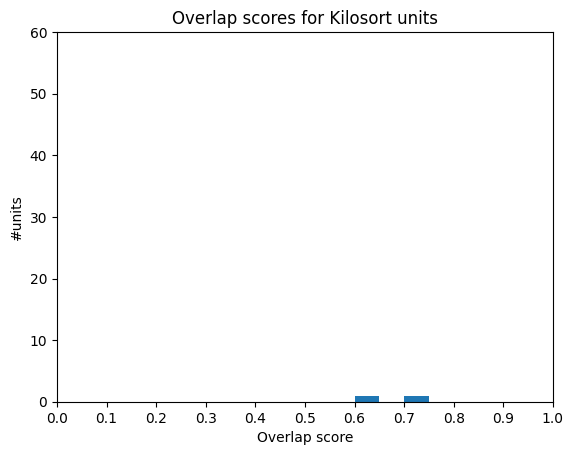

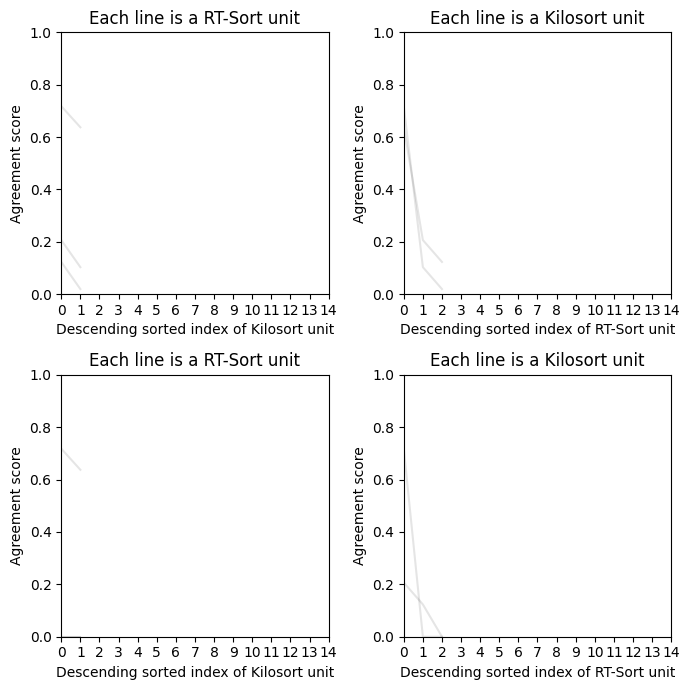

In [ ]:
rt = SpikeSorter(RECORDING, "RT-Sort", units=merges)
ks = SpikeSorter(RECORDING, "Kilosort", units=ks_units)

comp = Comparison(rt, ks, score_formula=2)
comp.summary()
comp.plot_line_comps()

## Kilosort units as sequences
Test assigning spikes by treating kilosort units as sequences

In [ ]:
%autoreload 2
from src.comparison import Comparison
from src import plot
from src.sorters.base import Unit
from src.sorters.kilosort import get_experts_kilosort

In [ ]:
kilosort = get_experts_kilosort(testing_ms=TRAINING_MS)

/data/MEAprojects/PropSignal/src/sorters/kilosort.py:186: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spike_times = np.array([spikes1[idx] for idx in range(len(comp.match12)) if comp.match12[idx] != -1])


Recording does not have scaled traces. Setting gain to 0.195


In [ ]:
# Setup kilosort units as sequences --> need to find root elec (max-amp elec)

all_ks_sequences = []
all_ks_spike_times = kilosort.get_spike_times()
chan_to_ks_seqs = {}

def job(idx):    
    cluster = F.CocCluster(-1, -1, -1, -1)
    cluster._spike_train = all_ks_spike_times[idx]
    
    all_waveforms = F.extract_waveforms(cluster, use_filt=True)   
    templates = np.mean(all_waveforms, axis=0)
    root_elec = np.argmin(np.min(templates, axis=1))
    
    cluster.root_elec = root_elec
    cluster.root_elecs = [root_elec]
    F.setup_cluster(cluster)
    
    return cluster

with Pool(processes=20) as pool:
    tasks = range(len(all_ks_spike_times))
    for idx, cluster in tqdm(enumerate(pool.imap(job, tasks)), total=len(tasks)):
        cluster.idx = idx
        all_ks_sequences.append(cluster)
        
for seq in chan_to_ks_seqs:
    if seq.root_elec not in chan_to_ks_seqs:
        chan_to_ks_seqs[seq.root_elec] = [seq]
    else:
        chan_to_ks_seqs[seq.root_elec].append(seq)

100%|██████████| 226/226 [02:50<00:00,  1.33it/s]


In [ ]:
"""
NOT USED ANYMORE:

    TODO:
    To use this, time_to_spike_match should contain all spikes with stringent threshold crossing
    So parts where seq continues if not pass a threshold should be commented
    And number of elec detections should be set to bare minimum value (1 stringent on root elec and 1 loose on a loose elec)

    NOTE: If a spike time not in time_to_spike_match dict, then DL model did not detect stringent detection
"""
F.assign_spikes(all_ks_sequences, TRAINING_MS,
                interelec=True, only_max_amps=False,
                verbose=True)

100%|██████████| 2451452/2451452 [18:20<00:00, 2227.67it/s]


In [ ]:
# Naive way to check precision and recall (does not account for location of units when finding spike match)

all_prop_spikes = []
for seq in all_ks_sequences:
    all_prop_spikes += seq._spike_train 
all_prop_spikes = np.sort(all_prop_spikes)

all_ks_spikes = []
for spike_train in all_ks_spike_times:
    all_ks_spikes.extend(spike_train)
all_ks_spikes = np.sort(all_ks_spikes)

matching_prop_times, unmatched_prop_times, unmatched_ks_times = Comparison.get_matching_events(all_prop_spikes, all_ks_spikes)

# num_matches = len(matching_prop_times)
# print(f"#matches: {num_matches}")
# print(f"#matches/#rt_sort: {num_matches/(len(unmatched_prop_times) + num_matches)*100:.1f}%")
# print(f"#matches/#kilosort: {num_matches/(len(unmatched_ks_times) + num_matches)*100:.1f}%")

tp = len(matching_prop_times)
fp = len(unmatched_prop_times)
fn = len(unmatched_ks_times)
print(f"For RT-Sort, relative to kilosort")
print(f"Precision: {tp / (tp+fp) *100:.1f}%")
print(f"Recall: {tp / (tp + fn) *100:.1f}%")

For RT-Sort, relative to kilosort
Precision: 65.1%
Recall: 70.4%


In [ ]:
# Correct way to check precision and recall

# Need to format as Unit objects for F.select_prop_spikes_within_kilosort_spikes
all_ks_units = []  # Contains spikes detected by kilosort
all_prop_units = []  # Contains spikes detected with rt_sort method
for idx, (ks_spike_times, ks_sequence) in enumerate(zip(all_ks_spike_times, all_ks_sequences)):
    all_ks_units.append(Unit(idx, ks_spike_times, ks_sequence.root_elec, None))
    all_prop_units.append(Unit(idx, ks_sequence.spike_train, ks_sequence.root_elec, None))

# Spikes detected by 1) prop and kilosort 2) prop but not kilosort
prop_and_ks_units, prop_only_units, ks_only_units = F.select_prop_spikes_within_kilosort_spikes(all_prop_units, all_ks_units, return_ks_only_units=True)

# Find precision and recall (sanity check)
tp = sum(len(unit.spike_train) for unit in prop_and_ks_units)
fp = sum(len(unit.spike_train) for unit in prop_only_units)
fn = sum(len(unit.spike_train) for unit in ks_only_units)
print(f"For RT-Sort, relative to kilosort")
print(f"Precision: {tp / (tp+fp) *100:.1f}%")
print(f"Recall: {tp / (tp + fn) *100:.1f}%")

For RT-Sort, relative to kilosort
Precision: 52.5%
Recall: 56.8%


In [ ]:
# Get spike data for kilosort only spikes
F.set_ks_only_spike_match_scores(ks_only_units, all_ks_sequences)

100%|██████████| 226/226 [00:44<00:00,  5.02it/s]

Undetectable sequences: [44, 212]


Num. inner loose electrodes


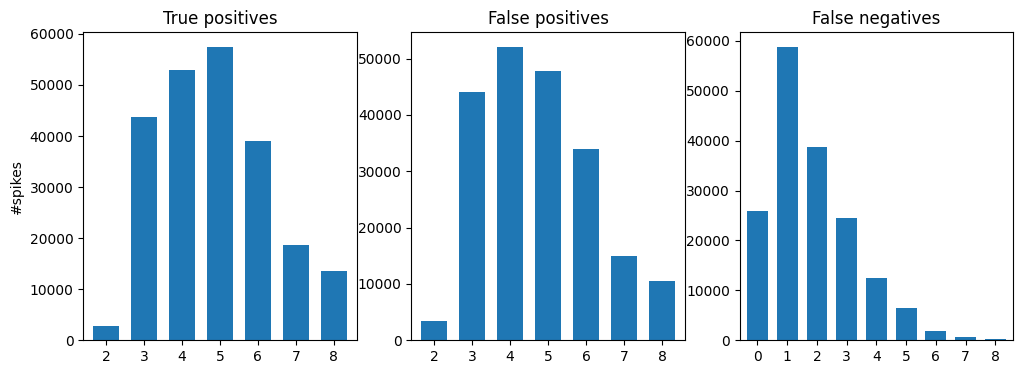

In [ ]:
"""
For each metric, plot histograms for all:
    1. True positives (prop_and_ks_units)
    2. False positives (prop_only_units)
    3. False negatives (ks_only_units)
    
metrics: (elec, num_inner_loose_elecs, num_loose_elecs, fraction_loose_elecs, latency_diff, amp_median_diff, score)
"""
metric_idx = 1  # metric index in time_to_spike_match[time]
print("Num. inner loose electrodes")  

fig, (a0, a1, a2) = plt.subplots(1, 3, figsize=(12, 4))
true_positives, false_positives, false_negatives = F.get_tp_fp_fn(metric_idx, all_ks_sequences, prop_and_ks_units, prop_only_units, ks_only_units)
              
plot.bar(true_positives, ax=a0)
plot.bar(false_positives, ax=a1)
plot.bar(false_negatives, ax=a2)

a0.set_ylabel("#spikes")
a0.set_title("True positives")
a1.set_title("False positives")
a2.set_title("False negatives")

plt.show()

Num. loose elecs


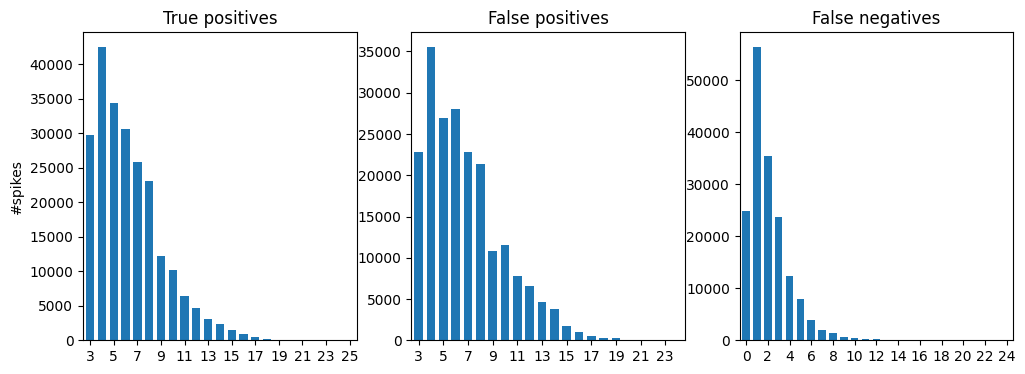

In [ ]:
metric_idx = 2 
print(f"Num. loose elecs")
##
fig, (a0, a1, a2) = plt.subplots(1, 3, figsize=(12, 4))
true_positives, false_positives, false_negatives = F.get_tp_fp_fn(metric_idx, all_ks_sequences, prop_and_ks_units, prop_only_units, ks_only_units)
         
plot.bar(true_positives, ax=a0)
plot.bar(false_positives, ax=a1)
plot.bar(false_negatives, ax=a2)

for ax in (a0, a1, a2):
    ax.set_xticks(ax.get_xticks()[::2])
    
a0.set_ylabel("#spikes")
a0.set_title("True positives")
a1.set_title("False positives")
a2.set_title("False negatives")

plt.show()

Percent loose elecs


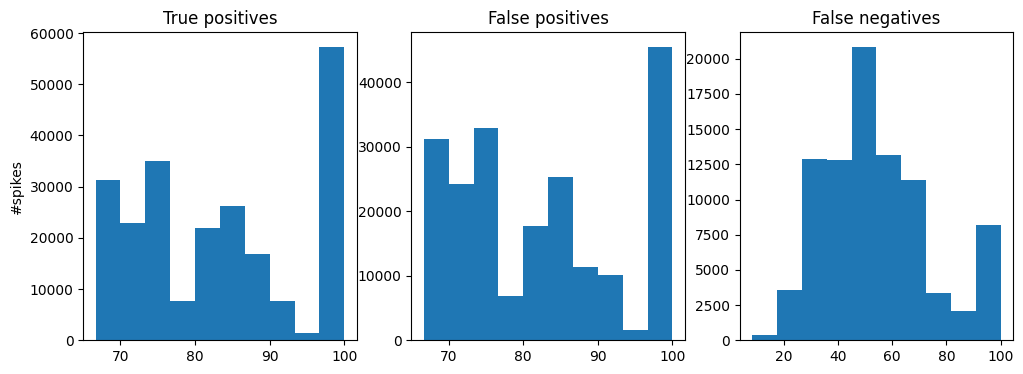

In [ ]:
metric_idx = 3
print(f"Percent loose elecs")
##
fig, (a0, a1, a2) = plt.subplots(1, 3, figsize=(12, 4))
true_positives, false_positives, false_negatives = F.get_tp_fp_fn(metric_idx, all_ks_sequences, prop_and_ks_units, prop_only_units, ks_only_units)
         
kwargs = {"bins": 10}
plot.hist(np.array(true_positives)*100, axis=a0, **kwargs)
plot.hist(np.array(false_positives)*100, axis=a1, **kwargs)
plot.hist(np.array(false_negatives)*100, axis=a2, **kwargs)

# for ax in (a0, a1):
#     ax.set_xticks(ax.get_xticks()[::2])
    
a0.set_ylabel("#spikes")
a0.set_title("True positives")
a1.set_title("False positives")
a2.set_title("False negatives")

plt.show()

Latency difference


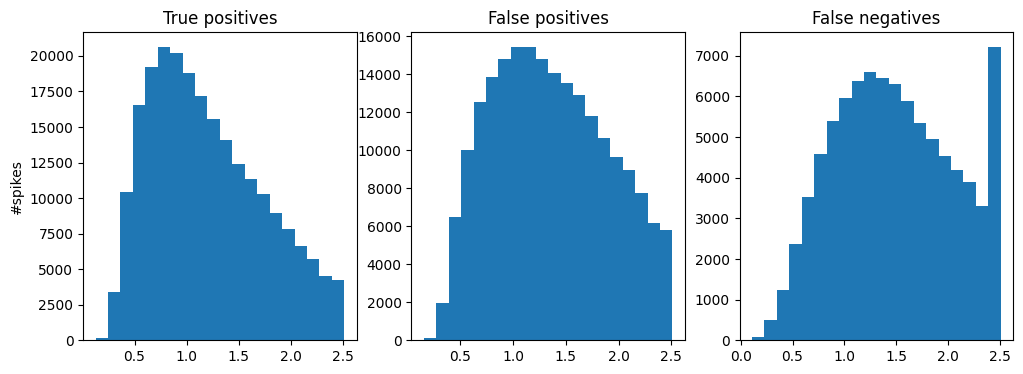

In [ ]:
metric_idx = 4
print(f"Latency difference")
##
fig, (a0, a1, a2) = plt.subplots(1, 3, figsize=(12, 4))
true_positives, false_positives, false_negatives = F.get_tp_fp_fn(metric_idx, all_ks_sequences, prop_and_ks_units, prop_only_units, ks_only_units)
         
kwargs = {"bins": 20}
plot.hist(true_positives, axis=a0, **kwargs)
plot.hist(false_positives, axis=a1, **kwargs)
plot.hist(false_negatives, axis=a2, **kwargs)
    
a0.set_ylabel("#spikes")
a0.set_title("True positives")
a1.set_title("False positives")
a2.set_title("False negatives")

plt.show()

Amplitude difference


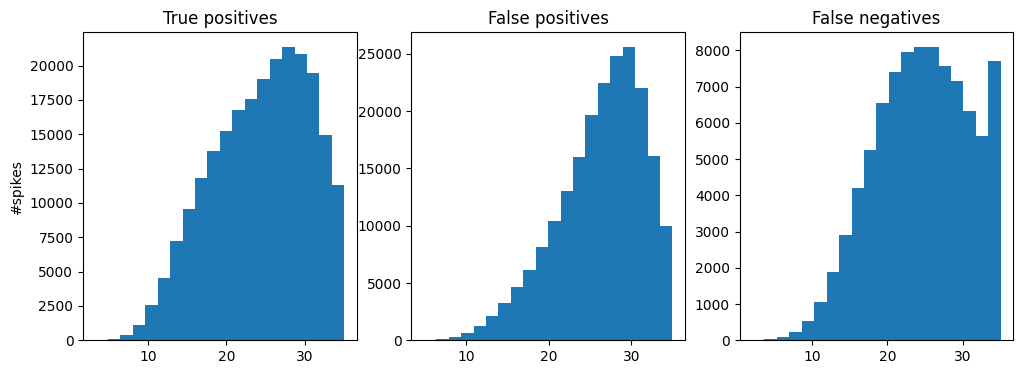

In [ ]:
metric_idx = 5
print(f"Amplitude difference")
##
fig, (a0, a1, a2) = plt.subplots(1, 3, figsize=(12, 4))
true_positives, false_positives, false_negatives = F.get_tp_fp_fn(metric_idx, all_ks_sequences, prop_and_ks_units, prop_only_units, ks_only_units)
         
kwargs = {"bins": 20}
plot.hist(np.array(true_positives)*100, axis=a0, **kwargs)
plot.hist(np.array(false_positives)*100, axis=a1, **kwargs)
plot.hist(np.array(false_negatives)*100, axis=a2, **kwargs)
    
a0.set_ylabel("#spikes")
a0.set_title("True positives")
a1.set_title("False positives")
a2.set_title("False negatives")

plt.show()

#### Scatter plots
metrics: (elec, num_inner_loose_elecs, num_loose_elecs, fraction_loose_elecs, latency_diff, amp_median_diff, score)

In [ ]:
all_true_positives, all_false_positives, all_false_negatives = F.get_spike_metrics(all_ks_sequences, prop_and_ks_units, prop_only_units, ks_only_units)

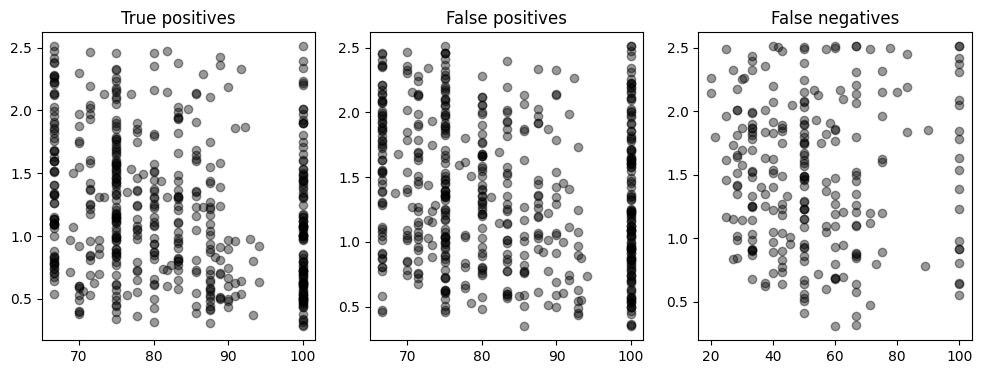

In [ ]:
x_metric = 3  # fraction_loose_elecs 
y_metric = 4  # latency_diff

num_spikes = 500  # for each subplot
##
np.random.seed(231)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, spikes in zip(axes, (all_true_positives, all_false_positives, all_false_negatives)):
    for idx in np.random.choice(len(spikes), num_spikes, replace=False):
        metrics = spikes[idx]
        x = metrics[x_metric] * 100  # To make into percent
        y = metrics[y_metric]
        if np.isnan(x) or np.isnan(y):
            continue
        
        ax.scatter(x, y, color="black", alpha=0.4)
      
a0, a1, a2 = axes  
a0.set_title("True positives")
a1.set_title("False positives")
a2.set_title("False negatives")
plt.show()

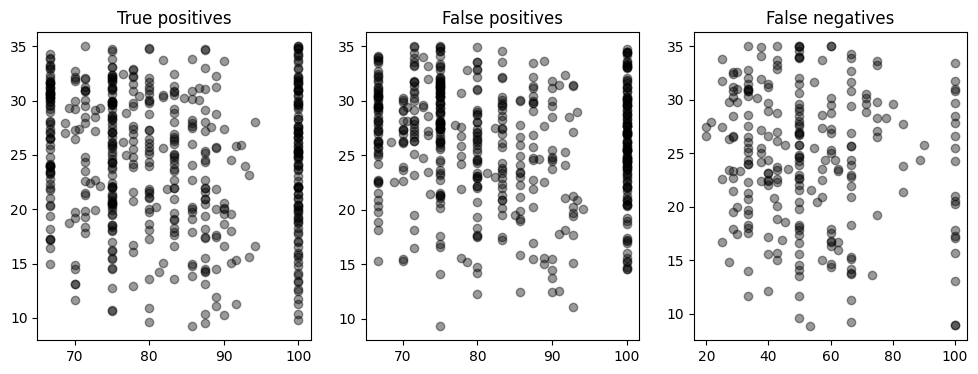

In [ ]:
x_metric = 3  # fraction_loose_elecs 
y_metric = 5  # amp_diff

num_spikes = 500  # for each subplot
##
np.random.seed(231)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, spikes in zip(axes, (all_true_positives, all_false_positives, all_false_negatives)):
    for idx in np.random.choice(len(spikes), num_spikes, replace=False):
        metrics = spikes[idx]
        x = metrics[x_metric] * 100  # To make into percent
        y = metrics[y_metric] * 100  # To make into percent
        if np.isnan(x) or np.isnan(y):
            continue
        
        ax.scatter(x, y, color="black", alpha=0.4)
      
a0, a1, a2 = axes  
a0.set_title("True positives")
a1.set_title("False positives")
a2.set_title("False negatives")
plt.show()

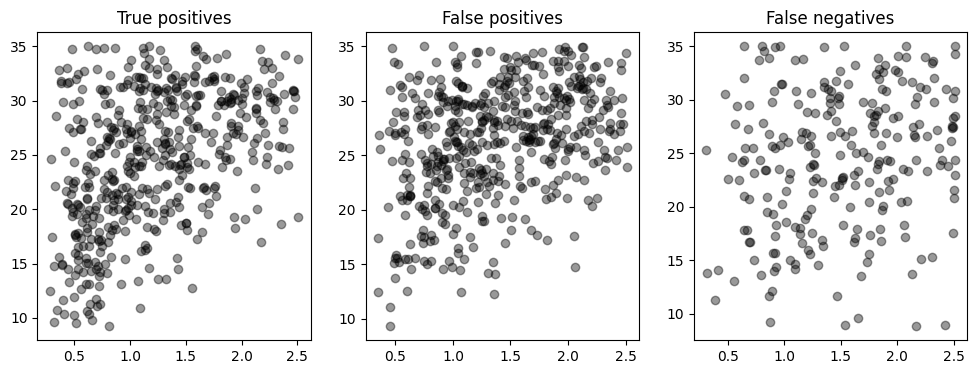

In [ ]:
x_metric = 4  # latency_diff 
y_metric = 5  # amp_diff

num_spikes = 500  # for each subplot
##
np.random.seed(231)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, spikes in zip(axes, (all_true_positives, all_false_positives, all_false_negatives)):
    for idx in np.random.choice(len(spikes), num_spikes, replace=False):
        metrics = spikes[idx]
        x = metrics[x_metric] 
        y = metrics[y_metric] * 100  # To make into percent
        if np.isnan(x) or np.isnan(y):
            continue
        
        ax.scatter(x, y, color="black", alpha=0.4)
      
a0, a1, a2 = axes  
a0.set_title("True positives")
a1.set_title("False positives")
a2.set_title("False negatives")
plt.show()

#### Footprints

--------------------------------------------------


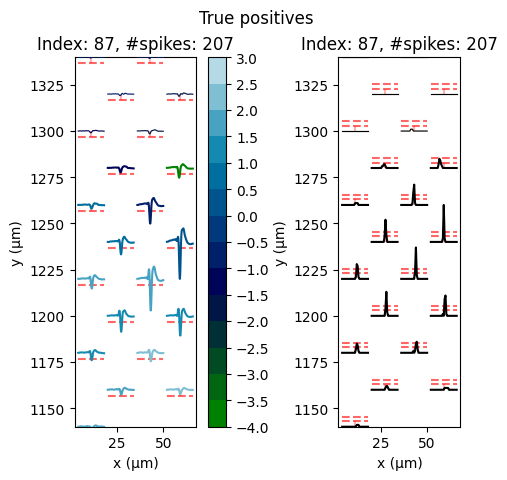

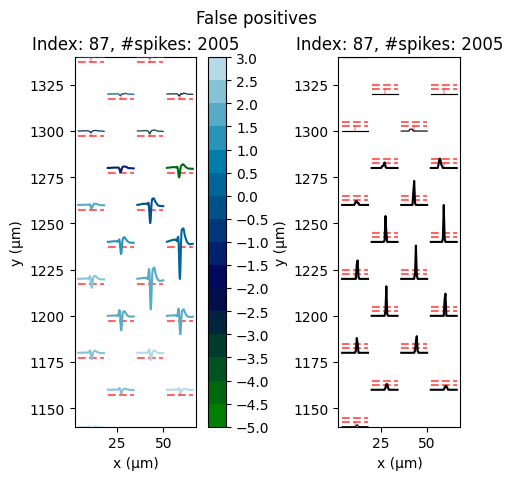

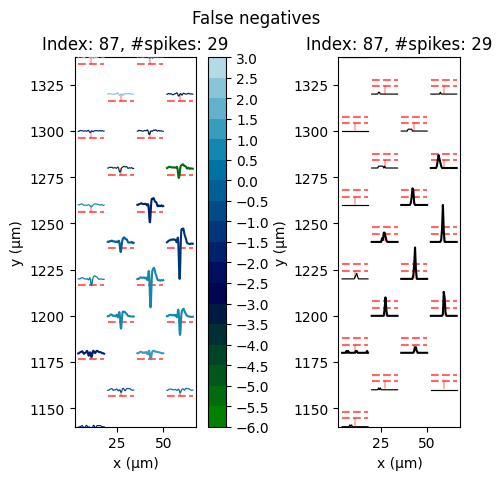

In [ ]:
num_units = 1
##
np.random.seed(231)
ind = np.random.choice(len(prop_and_ks_units), num_units)

# for prop_and_ks, prop_only, ks_only in zip(prop_and_ks_units, prop_only_units, ks_only_units):
for idx in ind:
    prop_and_ks, prop_only, ks_only = prop_and_ks_units[idx], prop_only_units[idx], ks_only_units[idx]
    print("-"*50)
    
    F.plot_elec_probs(prop_and_ks)
    plt.suptitle("True positives")
    plt.show()
    
    F.plot_elec_probs(prop_only)
    plt.suptitle("False positives")
    plt.show()
    
    F.plot_elec_probs(ks_only)
    plt.suptitle("False negatives")
    plt.show()

#### Save footprints

In [ ]:
SAVE_ROOT = Path("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231219/footprints")

In [ ]:
for prop_and_ks, prop_only, ks_only in zip(tqdm(prop_and_ks_units), prop_only_units, ks_only_units):
    # For testing
    # idx = 44
    # prop_and_ks, prop_only, ks_only = prop_and_ks_units[idx], prop_only_units[idx], ks_only_units[idx]

    save_path = SAVE_ROOT / str(prop_and_ks.idx)
    save_path.mkdir(parents=True, exist_ok=True)

    if len(prop_and_ks.spike_train) > 0:
        F.plot_elec_probs(prop_and_ks)
        plt.suptitle("True positives")
        plt.savefig(save_path / "true_positives.jpg", format="jpg")
        plt.close()

    if len(prop_only.spike_train) > 0:
        F.plot_elec_probs(prop_only)
        plt.suptitle("False positives")
        plt.savefig(save_path / "false_positives.jpg", format="jpg")
        plt.close()

    if len(ks_only.spike_train) > 0:
        F.plot_elec_probs(ks_only)
        plt.suptitle("False negatives")
        plt.savefig(save_path / "false_negatives.jpg", format="jpg")
        plt.close()

100%|██████████| 226/226 [13:57<00:00,  3.70s/it]


#### Save sequences

In [ ]:
utils.pickle_dump(all_ks_sequences, SAVE_ROOT.parent / "all_ks_sequences.pickle")

PicklingError: Can't pickle <class 'src.run_alg.si_rec9.CocCluster'>: it's not the same object as src.run_alg.si_rec9.CocCluster

In [ ]:
prop_signal = F.clusters_to_sorter(all_ks_sequences)
prop_signal.recording = None
utils.pickle_dump(prop_signal, SAVE_ROOT.parent / "ks_as_prop_signal.pickle")